# Analyze adsorption isotherm anomalies

In [1]:
import json
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import pprint
import os
import pygaps
import scipy

## Lets make a Python class for an adsorption isotherm

### This is usually referred to as class-based Object-Oriented Programming (OOP). 

#### [Here](https://pythonprogramming.net/introduction-learn-python-3-tutorials/)'s a tutorial series on Python if you want to learn the basics, and [Here](https://pythonprogramming.net/introduction-intermediate-python-tutorial/)'s an intermediate Python tutorial if the basic one is too easy.

#### More specifically, [This](https://pythonprogramming.net/object-oriented-programming-introduction-intermediate-python-tutorial/) is a tutorial on OOP in Python that I recommend, which introduces Classes

In [2]:
class Isotherm:
    # In Python classes, there is one required function you have to define, __init__ (for initialization)
    def __init__(self, filename):
        # This if-else sentence loads in the isotherm data. If you have extracted the isotherms into your directory, 
        #  you will load it directly, but if you haven't you'll have to download it from the NIST database.
        if os.path.isfile('isotherms/' + filename + '.json'):
            with open('isotherms/' + filename + '.json') as infile:
                isotherm_data = json.load(infile)
        else:
            url = "https://adsorption.nist.gov/isodb/api/isotherm/" + filename + ".json"
            isotherm_data = json.loads(requests.get(url).content)

        
        self.filename = filename
        self.doi = isotherm_data['DOI']
        assert len(isotherm_data['adsorbates']) < 2
        self.adsorbate = isotherm_data['adsorbates'][0]['name']
        self.inchikey = isotherm_data['adsorbates'][0]['InChIKey']
        self.adsorbent = isotherm_data['adsorbent']['name']
        self.category = isotherm_data['category']
        self.temperature = isotherm_data['temperature']
        self.adsorptionUnits = isotherm_data['adsorptionUnits']
        self.pressureUnits = isotherm_data['pressureUnits']
        self.pressure = np.array([isotherm_data['isotherm_data'][i]['pressure'] for i in range(len(isotherm_data['isotherm_data']))])
        self.adsorption = np.array([isotherm_data['isotherm_data'][i]['species_data'][0]['adsorption'] for i in range(len(isotherm_data['isotherm_data']))])
        self.henry_constant = None
        
    # Lets define a few helper functions first
    def _get_formula_from_inchikey(self):
        # Usually if there's an underscore in front of a function name, 
        #  it's meant for internal use
        url = "https://adsorbents.nist.gov/isodb/api/gas/" + self.inchikey + ".json"
        gas_data = json.loads(requests.get(url).content)
        self.formula = gas_data['formula']
    
    def get_molecular_weight(self):
        self._get_formula_from_inchikey()
        # We will need to read in the atomic masses to compute the molecular weight (mw):
        atomic_masses = pd.read_csv('data/atomicmasses.csv')
        
        # This splits the formula up into elements plus their frequency
        start_i = 0
        elements = []
        for end_i, letter in enumerate(self.formula[1:], start=1):
            if letter.isupper():
                elements.append([start_i, end_i])
                start_i = end_i
        elements.append([start_i, len(self.formula)])

        # This calculates the molecular weight of each type of element
        self.mw = 0
        for element in elements:
            form = self.formula[element[0]:element[1]]
            for i, letter in enumerate(form):
                if letter.isdigit():
                    element_mw = np.float(atomic_masses[atomic_masses.atom == form[:i]]['mass'])
                    self.mw = self.mw + element_mw * np.int(form[i:])
                    break
                if form.isalpha():
                    element_mw = np.float(atomic_masses[atomic_masses.atom == form]['mass'])
                    self.mw = self.mw + element_mw
                    break
        return self.mw
        
    def convert_units(self):
        # This will convert the pressure and adsorption to 'bar' and 'mmol/g', respectively, if needed
        # Pressure Units:
        assert self.pressureUnits == 'bar'

        # Adsorption Units:
        assert self.adsorptionUnits in ['cm3(STP)/g','g/g','mg/g','ml/g','mmol/g','mmol/kg','mol/g','wt%']

        aConversion = 0.0
        if self.adsorptionUnits == 'mmol/g':
            aConversion = 1.0
        elif self.adsorptionUnits == 'mmol/kg':
            aConversion = 1.0 / 1000.0
        elif self.adsorptionUnits == 'mol/g':
            aConversion = 1000.0
        elif self.adsorptionUnits in ['wt%', 'g/g']:
            mw = self.get_molecular_weight()
            aConversion = 1000.0 / mw
        elif self.adsorptionUnits in ['ml/g', 'cm3(STP)/g']:
            aConversion = 1.0 / 22.4
        elif self.adsorptionUnits == 'mg/g':
            mw = self.get_molecular_weight()
            aConversion = 1.0 / mw
        else:
            raise Exception('Something went horribly wrong!')

        self.adsorption = self.adsorption * aConversion
        self.adsorptionUnits = 'mmol/g'
        
    def fit_henry_constant(self, max_adjrms, verbose):
        # This will fit a Henry constant to the adsorption isotherm.
        # `max_adjrms` is a parameter used for the fitting procedure. 
        #  The default value is 0.01, but we can play around with this.
        # `verbose=True` will create a plot of the fit and give additional information
        # If the adsorption units are not in 'mmol/g' and the pressure units are not in 'bar',
        #  the assertion below will throw an error. Use `convert_units` to switch to the correct units
        assert self.adsorptionUnits == 'mmol/g' and self.pressureUnits == 'bar'
        isotherm = pygaps.PointIsotherm(
            pressure=self.pressure,
            loading=self.adsorption,
            material_name=self.adsorbent,
            material_batch='',
            t_iso=self.temperature,
            adsorbate=self.adsorbate)
        try:
            self.henry_constant = pygaps.initial_henry_slope(isotherm, max_adjrms, logx=False, verbose=verbose)
            return self.henry_constant
        except Exception as e:
            self.error = e
            print('Fitting procedure failed! See `self.error` as to why...')
            
    def flag_isotherm(self, henry_df):
        henry_df['ok'].loc[henry_df['filename'] == self.filename] = False
        return
    
    def unflag_isotherm(self, henry_df):
        henry_df['ok'].loc[henry_df['filename'] == self.filename] = True
        return
    
    def add_comment(self, comment, henry_df):
        henry_df['comment'].loc[henry_df['filename'] == self.filename] = comment
        return
    
    def plot_isotherm(self):
        fig = plt.figure(figsize=(8,6))
        bad_datapoints = self.pressure[self.pressure < 0]
        good_datapoints = self.pressure[self.pressure >= 0]
        plt.scatter(self.pressure, self.adsorption, marker='o', label='Experimental')
        if self.henry_constant:
            plt.plot([0, self.pressure[-1]], [0, self.pressure[-1] * self.henry_constant], color='red', label="Henry's Law")
        plt.xlabel('Pressure [{}]'.format(self.pressureUnits))
        plt.ylabel('Adsorption [{}]'.format(self.adsorptionUnits))
        plt.ylim([-0.2*self.adsorption[-1], self.adsorption[-1] * 1.2])
        plt.legend()
        plt.show()
        return

In [3]:
henry_df = pd.read_csv('henry_df.csv')
henry_df.head(10)

,Unnamed: 0,gas,material,henry_constant,filename,ok,z_score,comment
0,0,CURLTUGMZLYLDI-UHFFFAOYSA-N,NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b,0.466816,10.8888s10450-012-9407-1.Isotherm11,True,0.060536,NaN
1,1,CURLTUGMZLYLDI-UHFFFAOYSA-N,NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b,0.953870,10.8888s10450-012-9407-1.Isotherm1,True,0.060520,NaN
2,2,CURLTUGMZLYLDI-UHFFFAOYSA-N,NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b,0.290830,10.8888jp206959k.Isotherm17,True,0.060542,NaN
3,3,CURLTUGMZLYLDI-UHFFFAOYSA-N,NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b,2.612494,10.8888Ja909263x.Isotherm2,True,0.060467,NaN
4,4,CURLTUGMZLYLDI-UHFFFAOYSA-N,NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b,0.962891,10.8888j.cej.2011.01.096.isotherm4b,True,0.060520,NaN
5,5,CURLTUGMZLYLDI-UHFFFAOYSA-N,NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b,2.661777,10.1039C4ee01009d.Isotherm22,True,0.060465,NaN
6,6,CURLTUGMZLYLDI-UHFFFAOYSA-N,NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b,2.136735,10.1039C4ee01009d.Isotherm21,True,0.060482,NaN
7,7,CURLTUGMZLYLDI-UHFFFAOYSA-N,NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b,2.434755,10.1039C4ee01009d.Isotherm20,True,0.060473,NaN
8,8,CURLTUGMZLYLDI-UHFFFAOYSA-N,NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b,1.297005,10.1039C4ee01009d.Isotherm19,True,0.060509,NaN
9,9,CURLTUGMZLYLDI-UHFFFAOYSA-N,NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b,1.263696,10.1039C4ee01009d.Isotherm18,True,0.060510,NaN


In [4]:
henry_df.sort_values(["henry_constant"], ascending = False, inplace = True)
henry_df.head(100)

,Unnamed: 0,gas,material,henry_constant,filename,ok,z_score,comment
961,961,UGFAIRIUMAVXCW-UHFFFAOYSA-N,NIST-MATDB-991daf7313251e7e607e2bab2da57e33,6.401857e+13,10.1016j.micromeso.2012.02.034.Isotherm2,False,8.246211,NaN
1560,1560,VNWKTOKETHGBQD-UHFFFAOYSA-N,NIST-MATDB-bbd809480ca8c8d0e4d066e70a9719d1,3.662595e+09,10.1016j.fluid.2014.08.020.Isotherm3,False,15.789991,NaN
1190,1190,VNWKTOKETHGBQD-UHFFFAOYSA-N,NIST-MATDB-2c9380bddc59f547484ff729eab7d7cb,2.593508e+09,10.1016j.fluid.2014.08.020.Isotherm2,False,11.158472,NaN
1191,1191,VNWKTOKETHGBQD-UHFFFAOYSA-N,NIST-MATDB-2c9380bddc59f547484ff729eab7d7cb,2.485209e+09,10.1016j.fluid.2014.08.020.Isotherm1,False,10.689296,NaN
1847,1847,HSFWRNGVRCDJHI-UHFFFAOYSA-N,NIST-MATDB-297c8ffe0f482757db45335130e02770,3.377586e+08,10.1007s11224-012-0120-1.isotherm35,False,5.058808,NaN
1821,1821,HSFWRNGVRCDJHI-UHFFFAOYSA-N,NIST-MATDB-1733c0f5ae26290495f099f06d0dd880,1.527369e+08,10.1007s11224-012-0120-1.isotherm36,True,2.145248,NaN
1849,1849,HSFWRNGVRCDJHI-UHFFFAOYSA-N,NIST-MATDB-297c8ffe0f482757db45335130e02770,9.760917e+06,10.1007s11224-012-0120-1.isotherm32,True,0.106214,NaN
1822,1822,HSFWRNGVRCDJHI-UHFFFAOYSA-N,NIST-MATDB-1733c0f5ae26290495f099f06d0dd880,9.610024e+06,10.1007s11224-012-0120-1.isotherm34,True,0.108590,NaN
1848,1848,HSFWRNGVRCDJHI-UHFFFAOYSA-N,NIST-MATDB-297c8ffe0f482757db45335130e02770,9.362430e+06,10.1007s11224-012-0120-1.isotherm33,True,0.112489,NaN
1823,1823,HSFWRNGVRCDJHI-UHFFFAOYSA-N,NIST-MATDB-1733c0f5ae26290495f099f06d0dd880,8.959582e+06,10.1007s11224-012-0120-1.isotherm31,True,0.118833,NaN


In [5]:
henry_df.loc[np.isnan(henry_df['henry_constant'])]

,Unnamed: 0,gas,material,henry_constant,filename,ok,z_score,comment
120,120,UFHFLCQGNIYNRP-UHFFFAOYSA-N,NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b,NaN,10.1021Jp074889i.Isotherm69,False,NaN,NaN
243,243,QGZKDVFQNNGYKY-UHFFFAOYSA-N,NIST-MATDB-035dc75dddd00241bd76627f78cbef2d,NaN,10.1021je000273plus.isotherm83,False,NaN,NaN
244,244,QGZKDVFQNNGYKY-UHFFFAOYSA-N,NIST-MATDB-035dc75dddd00241bd76627f78cbef2d,NaN,10.1021je000273plus.isotherm82,False,NaN,NaN
246,246,QGZKDVFQNNGYKY-UHFFFAOYSA-N,NIST-MATDB-035dc75dddd00241bd76627f78cbef2d,NaN,10.1021je000273plus.isotherm76,False,NaN,NaN
350,350,IJGRMHOSHXDMSA-UHFFFAOYSA-N,NIST-MATDB-453276ee992ed07dc207ed08b2b221ce,NaN,10.1039C1cc14685h.Isotherm6,False,NaN,NaN
719,719,IJGRMHOSHXDMSA-UHFFFAOYSA-N,NIST-MATDB-991daf7313251e7e607e2bab2da57e33,NaN,10.1021Je1002225.isotherm12,False,NaN,NaN
748,748,VNWKTOKETHGBQD-UHFFFAOYSA-N,NIST-MATDB-991daf7313251e7e607e2bab2da57e33,NaN,10.1039C4ra12432d.Isotherm5,False,NaN,NaN
894,894,UFHFLCQGNIYNRP-UHFFFAOYSA-N,NIST-MATDB-991daf7313251e7e607e2bab2da57e33,NaN,10.1016j.fluid.2013.11.029.Isotherm49,False,NaN,NaN
895,895,UFHFLCQGNIYNRP-UHFFFAOYSA-N,NIST-MATDB-991daf7313251e7e607e2bab2da57e33,NaN,10.1016j.egypro.2011.01.090.Isotherm1,False,NaN,NaN
975,975,XKRFYHLGVUSROY-UHFFFAOYSA-N,NIST-MATDB-991daf7313251e7e607e2bab2da57e33,NaN,10.1039C1cp20168a.Isotherm10,False,NaN,NaN


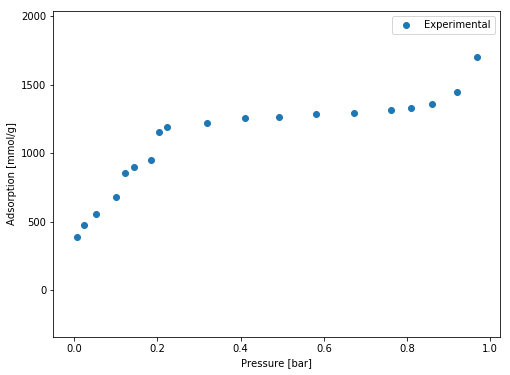

Calculated K = 69111.87562907842
Starting points: 20
Selected points: 2
Final adjusted root mean square difference: 0.0


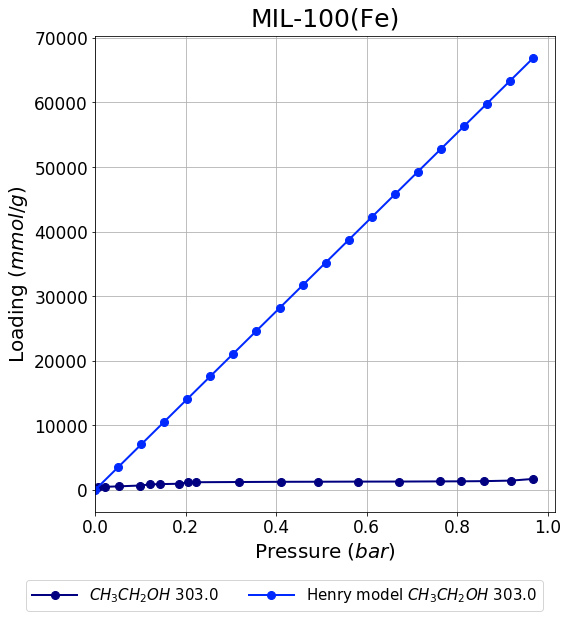

C:\Users\Owner\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


array([0.00561856, 0.02252   , 0.0535059 , 0.0999848 , 0.121112  ,
       0.143647  , 0.184492  , 0.20421   , 0.22252   , 0.318295  ,
       0.409844  , 0.492943  , 0.580266  , 0.671816  , 0.761957  ,
       0.808435  , 0.85914   , 0.919703  , 0.96759   ])

In [6]:
bad_iso2 = Isotherm('10.1016j.micromeso.2012.02.027.isotherm7')
bad_iso2.convert_units()
bad_iso2.plot_isotherm()
bad_iso2.pressure = bad_iso2.pressure #* 1e10
bad_iso2.fit_henry_constant(0.01, True)
bad_iso2.add_comment('Original units in P/P0 -- should recheck unit conversion', henry_df)
bad_iso2.pressure

In [7]:
bad_iso2.adsorption

array([ 388.30921993,  476.97295589,  556.46121293,  678.7531768 ,
        856.07630734,  895.8215212 ,  950.85268787, 1155.69357243,
       1189.32397103, 1222.95436963, 1253.52627525, 1265.75590578,
       1284.10035156, 1293.27148911, 1317.72857948, 1329.95821   ,
       1357.47379334, 1443.07903632, 1699.89259458])

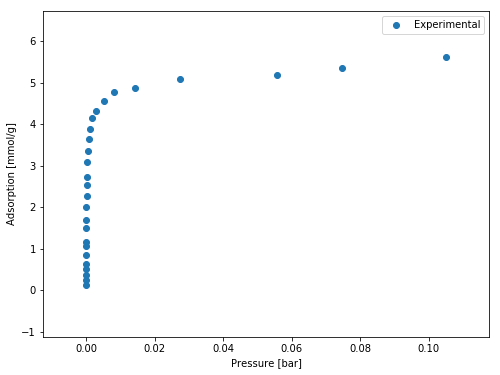

Calculated K = 109417.46177349259
Starting points: 28
Selected points: 4
Final adjusted root mean square difference: 0.002275135551331488


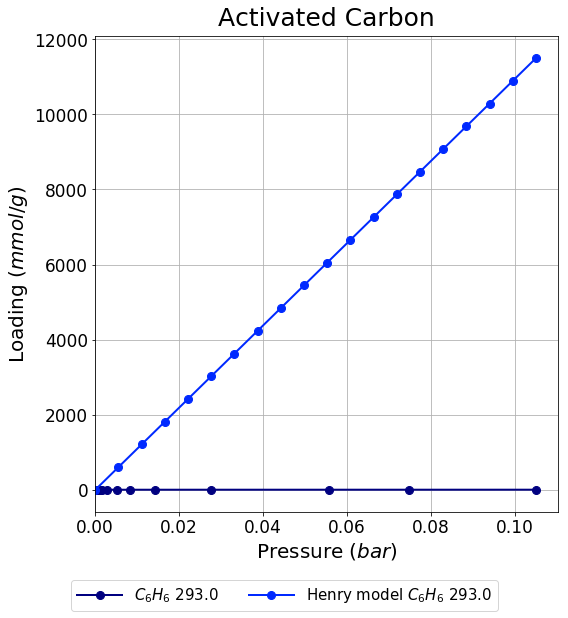

array([1.04000e-06, 2.36000e-06, 3.40000e-06, 6.87000e-06, 9.23000e-06,
       1.11000e-05, 1.39000e-05, 1.95000e-05, 2.94000e-05, 3.86000e-05,
       6.23000e-05, 1.00000e-04, 1.41000e-04, 1.90000e-04, 3.27000e-04,
       4.92000e-04, 7.94000e-04, 1.19476e-03, 1.68007e-03, 2.83357e-03,
       5.11622e-03, 8.24549e-03, 1.42263e-02, 2.74991e-02, 5.56267e-02,
       7.47466e-02, 1.05109e-01])

In [8]:
bad_iso2 = Isotherm('10.1021la010232r.Isotherm2')
bad_iso2.convert_units()
bad_iso2.plot_isotherm()
bad_iso2.pressure = bad_iso2.pressure #* 1e10
bad_iso2.fit_henry_constant(0.01, True)
bad_iso2.add_comment('Benzene adsorption, low pressure isotherm', henry_df)
bad_iso2.pressure

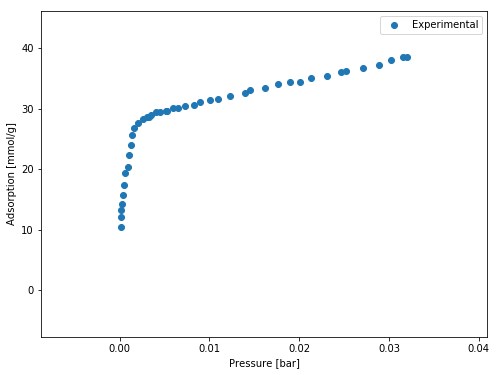

Calculated K = 63137.68122822176
Starting points: 45
Selected points: 2
Final adjusted root mean square difference: 0.0


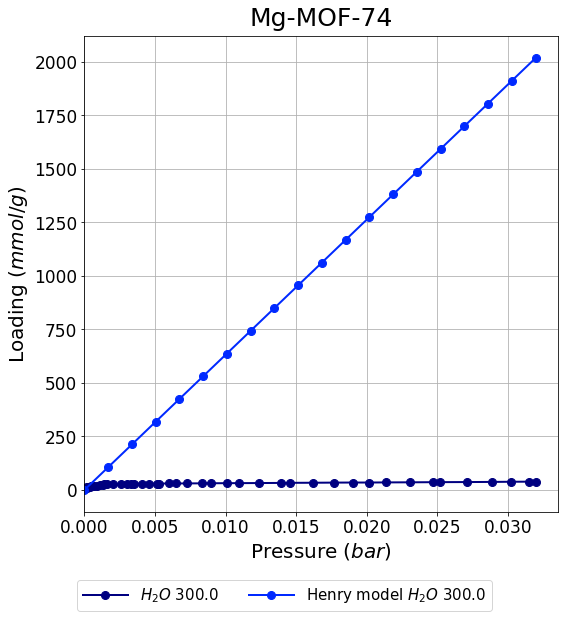

array([0.00021065, 0.00021148, 0.00021258, 0.0002649 , 0.00037382,
       0.0004826 , 0.00064605, 0.00092009, 0.00108354, 0.00130221,
       0.00141099, 0.00162994, 0.00201401, 0.00261799, 0.00300233,
       0.00327705, 0.00349655, 0.00410067, 0.00454023, 0.00514449,
       0.00525438, 0.00596839, 0.00646289, 0.00723185, 0.00833061,
       0.00893473, 0.0100883 , 0.0109673 , 0.0123406 , 0.0139336 ,
       0.0145377 , 0.0161858 , 0.0176689 , 0.0189873 , 0.0201412 ,
       0.0213495 , 0.0230526 , 0.0247005 , 0.0251949 , 0.0271177 ,
       0.0288755 , 0.0301936 , 0.031512  , 0.0319516 ])

In [9]:
bad_iso2 = Isotherm('10.1021Jp503778m.Isotherm7')
bad_iso2.convert_units()
bad_iso2.plot_isotherm()
bad_iso2.pressure = bad_iso2.pressure #* 1e10
bad_iso2.fit_henry_constant(0.01, True)
bad_iso2.add_comment('Water adsorption, non linear plot points on x axis', henry_df)
bad_iso2.pressure

In [10]:
bad_iso2.adsorption

array([13.2997, 12.0907, 10.4786, 14.3073, 15.7179, 17.33  , 19.3451,
       20.3526, 22.3678, 23.9798, 25.5919, 26.801 , 27.6071, 28.2116,
       28.6146, 28.6146, 29.0176, 29.4207, 29.4207, 29.6222, 29.6222,
       30.0252, 30.0252, 30.4282, 30.6297, 31.0327, 31.4358, 31.6373,
       32.0403, 32.6448, 33.0479, 33.4509, 34.0554, 34.4584, 34.4584,
       35.063 , 35.466 , 36.0705, 36.272 , 36.6751, 37.2796, 38.0856,
       38.4887, 38.4887])

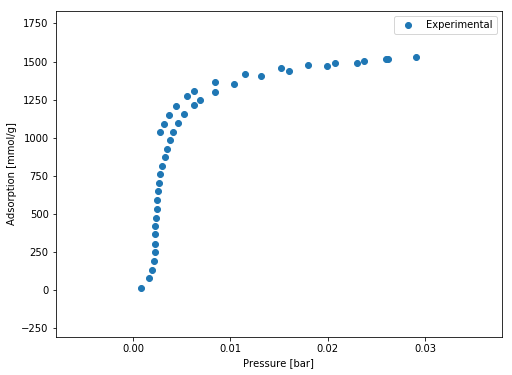

Calculated K = 41646.18387991569
Starting points: 45
Selected points: 3
Final adjusted root mean square difference: 0.007370136326508438


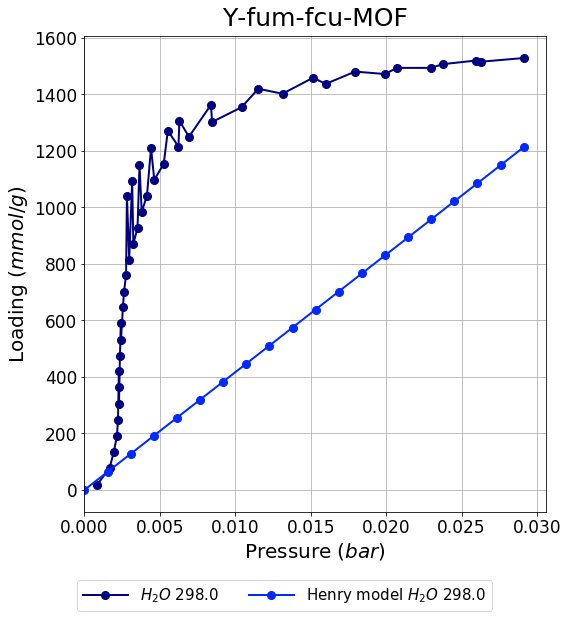

array([0.000837, 0.001672, 0.001949, 0.002156, 0.002223, 0.002285,
       0.002288, 0.00229 , 0.002353, 0.002417, 0.00242 , 0.002554,
       0.002622, 0.002759, 0.002816, 0.002966, 0.003163, 0.003242,
       0.003519, 0.003649, 0.003796, 0.004142, 0.004414, 0.004629,
       0.005254, 0.005528, 0.006229, 0.006295, 0.006926, 0.008387,
       0.00846 , 0.010412, 0.011526, 0.013133, 0.015155, 0.015994,
       0.017947, 0.019902, 0.020739, 0.022973, 0.023741, 0.025975,
       0.026254, 0.029116])

In [11]:
bad_iso2 = Isotherm('10.1002anie.201506345.Isotherm5')
bad_iso2.convert_units()
bad_iso2.plot_isotherm()
bad_iso2.pressure = bad_iso2.pressure #* 1e10
bad_iso2.fit_henry_constant(0.01, True)
bad_iso2.add_comment('Bad plot points completely off trend. Likely plotted desorption and adsorption', henry_df)
bad_iso2.pressure

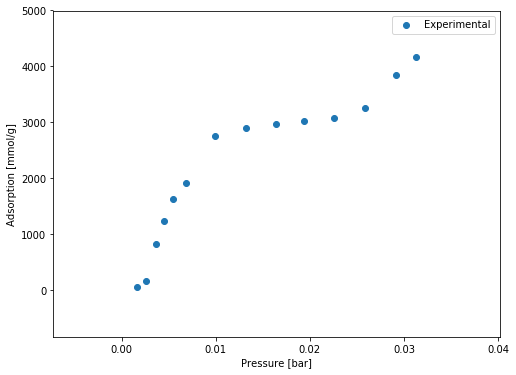

Calculated K = 54038.822207869365
Starting points: 15
Selected points: 3
Final adjusted root mean square difference: 0.00624590531943582


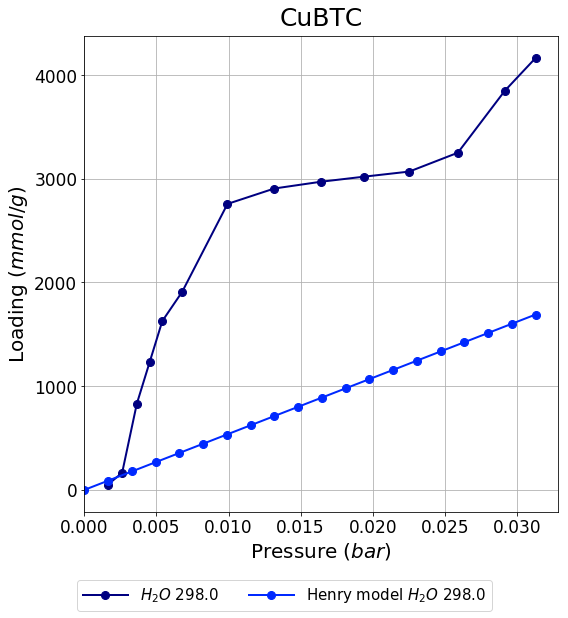

array([0.00162233, 0.0026231 , 0.00363928, 0.00452329, 0.00540731,
       0.00678681, 0.0099278 , 0.0131739 , 0.0164176 , 0.0194115 ,
       0.0225301 , 0.0259018 , 0.0291604 , 0.031289  ])

In [12]:
bad_iso2 = Isotherm('10.1016j.egypro.2009.01.166.Isotherm6')
bad_iso2.convert_units()
bad_iso2.plot_isotherm()
bad_iso2.pressure = bad_iso2.pressure #* 1e10
bad_iso2.fit_henry_constant(0.01, True)
bad_iso2.add_comment('water adsorption', henry_df)
bad_iso2.pressure

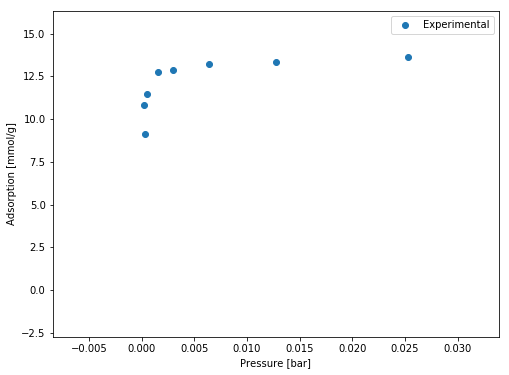

Calculated K = 52550.00000000001
Starting points: 9
Selected points: 2
Final adjusted root mean square difference: 0.0


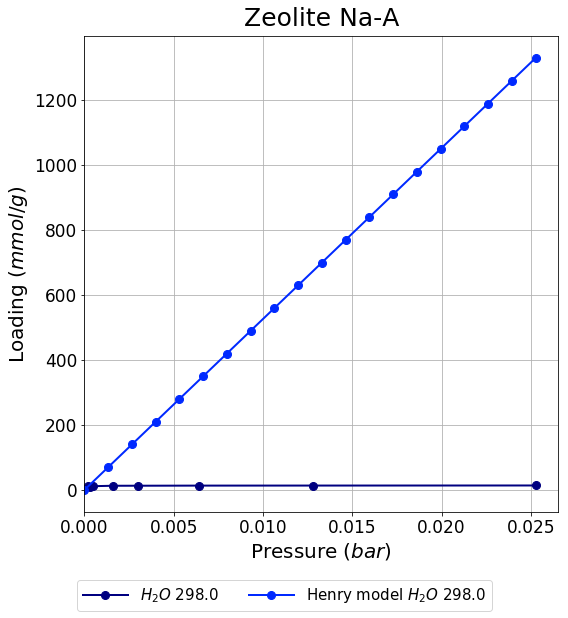

array([0.000206  , 0.000321  , 0.000492  , 0.00157914, 0.00300928,
       0.00644162, 0.0127915 , 0.0252623 ])

In [13]:
bad_iso2 = Isotherm('10.1252Jcej.37.67.isotherm3')
bad_iso2.convert_units()
bad_iso2.plot_isotherm()
bad_iso2.pressure = bad_iso2.pressure #* 1e10
bad_iso2.fit_henry_constant(0.01, True)
bad_iso2.add_comment('water adsorption', henry_df)
bad_iso2.pressure

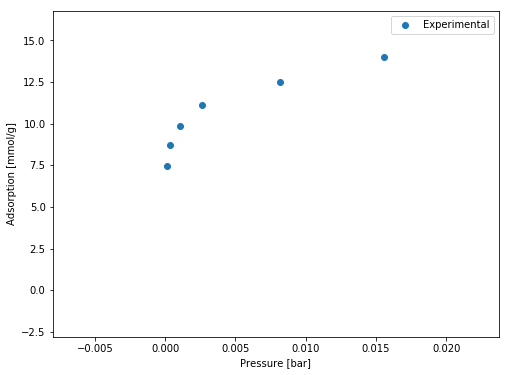

Calculated K = 50328.590259235476
Starting points: 7
Selected points: 2
Final adjusted root mean square difference: 0.0


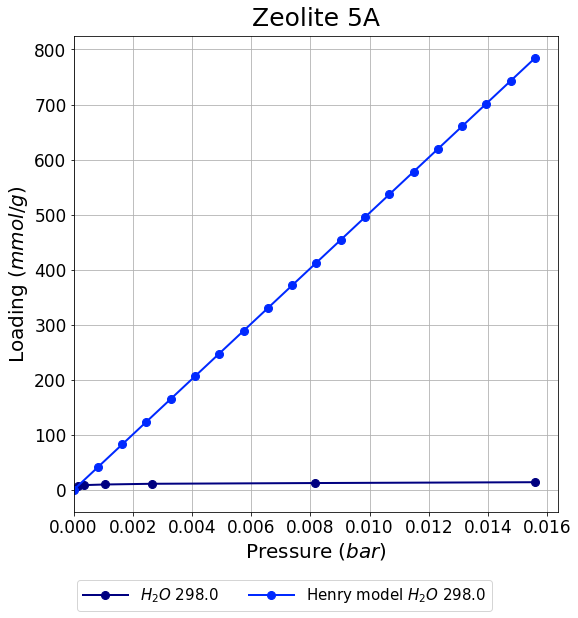

array([0.00014793, 0.00035565, 0.0010536 , 0.002641  , 0.00815764,
       0.0155863 ])

In [14]:
bad_iso2 = Isotherm('10.1021Je800900a.Isotherm53')
bad_iso2.convert_units()
bad_iso2.plot_isotherm()
bad_iso2.pressure = bad_iso2.pressure #* 1e10
bad_iso2.fit_henry_constant(0.01, True)
bad_iso2.add_comment('water adsorption', henry_df)
bad_iso2.pressure

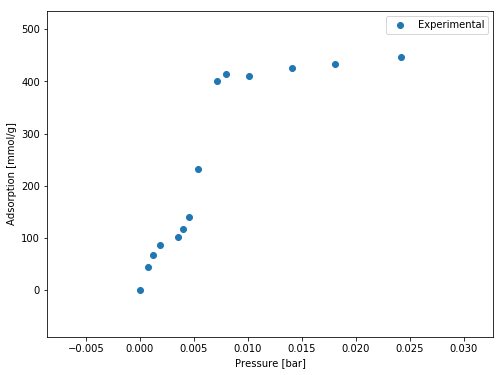

Calculated K = 57490.99040250207
Starting points: 14
Selected points: 3
Final adjusted root mean square difference: 0.004512469275158614


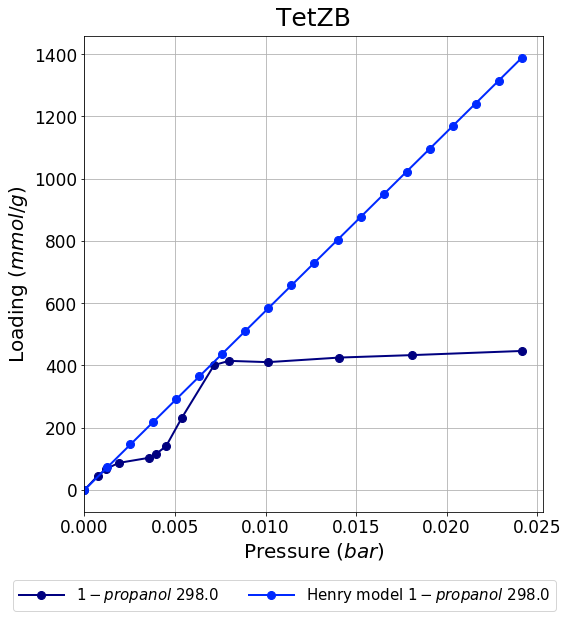

array([0.      , 0.000726, 0.00121 , 0.001889, 0.003542, 0.003979,
       0.004512, 0.005379, 0.007162, 0.007988, 0.01013 , 0.01407 ,
       0.018107, 0.02414 ])

In [15]:
bad_iso2 = Isotherm('10.1039c5cc00113g.Isotherm3')
bad_iso2.convert_units()
bad_iso2.plot_isotherm()
bad_iso2.pressure = bad_iso2.pressure #* 1e10
bad_iso2.fit_henry_constant(0.01, True)
bad_iso2.add_comment('propanol adsorption, low pressures', henry_df)
bad_iso2.pressure

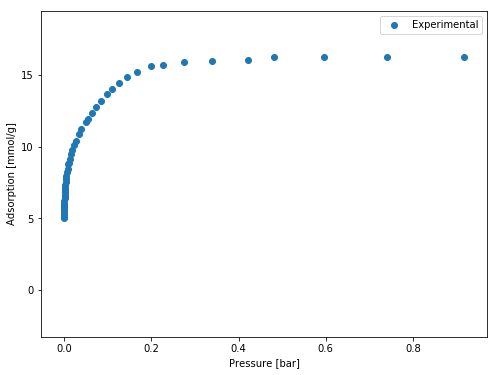

Calculated K = 48142.01842554165
Starting points: 52
Selected points: 2
Final adjusted root mean square difference: 7.802569031452251e-11


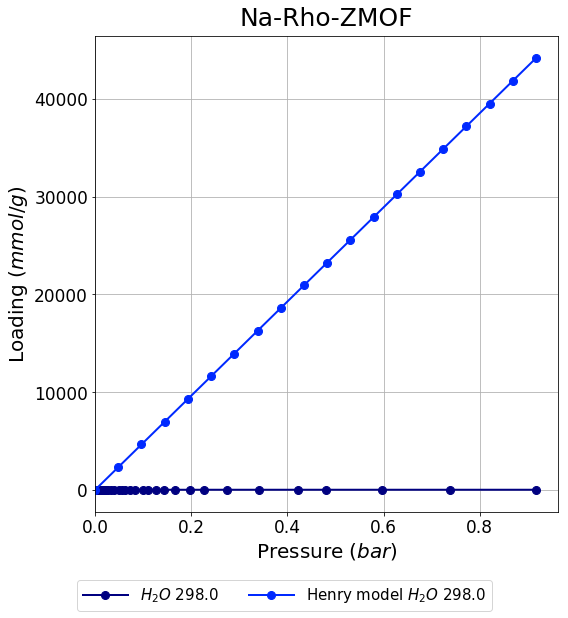

array([1.04409e-04, 1.26777e-04, 1.57297e-04, 1.90999e-04, 2.36979e-04,
       2.87753e-04, 3.57018e-04, 4.33511e-04, 5.37873e-04, 6.53116e-04,
       8.10345e-04, 9.62964e-04, 1.16928e-03, 1.41978e-03, 1.76157e-03,
       2.09334e-03, 2.43456e-03, 2.95617e-03, 3.66775e-03, 4.45359e-03,
       5.40779e-03, 6.56644e-03, 7.97333e-03, 9.27278e-03, 1.12595e-02,
       1.33801e-02, 1.59005e-02, 1.88951e-02, 2.24538e-02, 2.66827e-02,
       3.38275e-02, 3.93414e-02, 4.98758e-02, 5.55559e-02, 6.32325e-02,
       7.19681e-02, 8.36990e-02, 9.94626e-02, 1.10789e-01, 1.26096e-01,
       1.43519e-01, 1.66910e-01, 1.98346e-01, 2.25751e-01, 2.74119e-01,
       3.40107e-01, 4.21981e-01, 4.80285e-01, 5.95904e-01, 7.39353e-01,
       9.17338e-01])

In [16]:
bad_iso2 = Isotherm('10.1021Jp1033273.Isotherm15')
bad_iso2.convert_units()
bad_iso2.plot_isotherm()
bad_iso2.pressure = bad_iso2.pressure #* 1e10
bad_iso2.fit_henry_constant(0.01, True)
bad_iso2.add_comment('water adsorption', henry_df)
bad_iso2.pressure

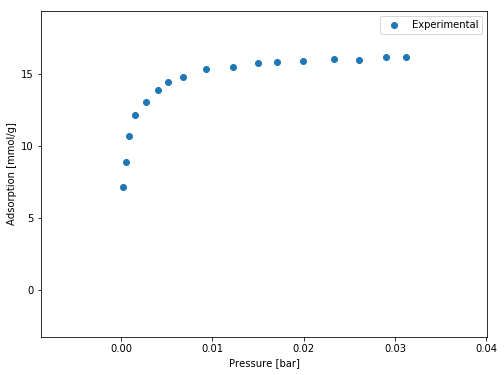

Calculated K = 43790.16107432026
Starting points: 18
Selected points: 2
Final adjusted root mean square difference: 0.0


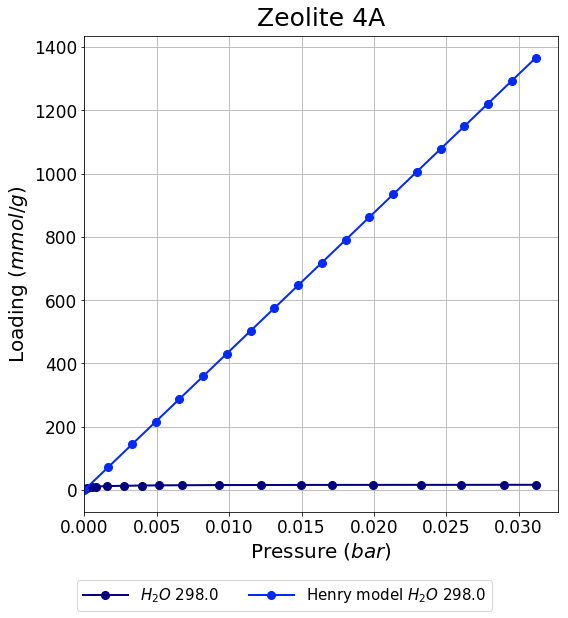

array([0.00016278, 0.00048835, 0.00081391, 0.00154643, 0.0027673 ,
       0.00398817, 0.00512765, 0.00675547, 0.0092786 , 0.0122087 ,
       0.014976  , 0.0170922 , 0.0199408 , 0.0232779 , 0.0260452 ,
       0.0289753 , 0.0311728 ])

In [17]:
bad_iso2 = Isotherm('10.1021Jp805923k.Isotherm1')
bad_iso2.convert_units()
bad_iso2.plot_isotherm()
bad_iso2.pressure = bad_iso2.pressure #* 1e10
bad_iso2.fit_henry_constant(0.01, True)
bad_iso2.add_comment('water adsorption', henry_df)
bad_iso2.pressure

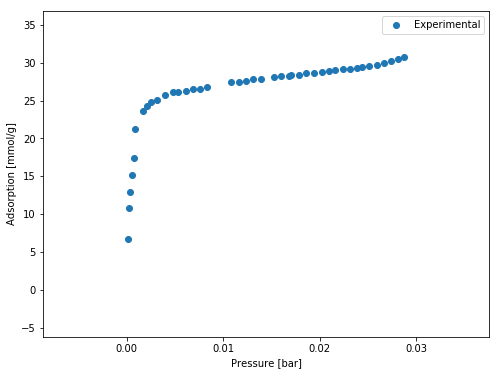

Calculated K = 44860.841124557286
Starting points: 43
Selected points: 3
Final adjusted root mean square difference: 0.006824718369487777


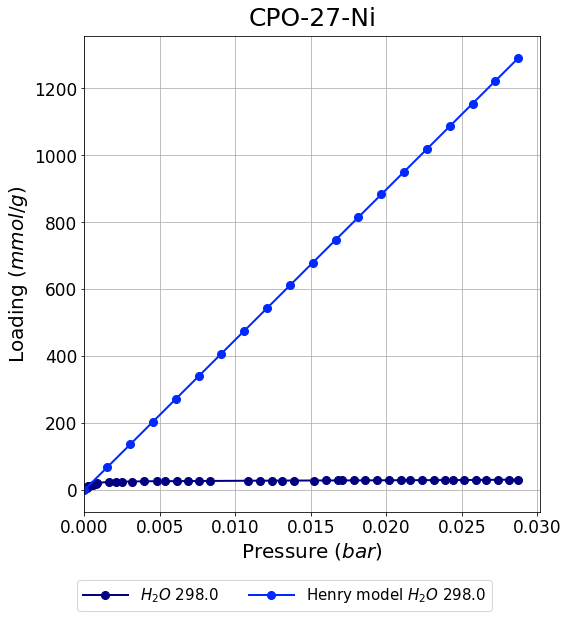

array([0.00015709, 0.00023563, 0.00031417, 0.0005498 , 0.00078542,
       0.00086397, 0.00164939, 0.00212065, 0.00251336, 0.0031417 ,
       0.00392713, 0.00479109, 0.00534089, 0.00612632, 0.0068332 ,
       0.00761862, 0.00832551, 0.0108389 , 0.0116243 , 0.0124097 ,
       0.0131166 , 0.013902  , 0.0152372 , 0.0160227 , 0.0168081 ,
       0.0170437 , 0.0178291 , 0.0186146 , 0.0194    , 0.0201854 ,
       0.0209708 , 0.0215992 , 0.0223846 , 0.02317   , 0.0238769 ,
       0.0244267 , 0.0251336 , 0.025919  , 0.0266259 , 0.0274113 ,
       0.0281182 , 0.0287466 ])

In [18]:
bad_iso2 = Isotherm('10.1039C2dt31112g.Isotherm10')
bad_iso2.convert_units()
bad_iso2.plot_isotherm()
bad_iso2.pressure = bad_iso2.pressure #* 1e10
bad_iso2.fit_henry_constant(0.01, True)
bad_iso2.add_comment('Created new plot points, high KH likely due to adsorption of water', henry_df)
bad_iso2.pressure

In [19]:
bad_iso2.adsorption

array([ 6.74497, 10.7718 , 12.9866 , 15.2013 , 17.4161 , 21.2416 ,
       23.6577 , 24.2617 , 24.7651 , 25.0671 , 25.6711 , 26.0738 ,
       26.0738 , 26.2752 , 26.4765 , 26.5772 , 26.7785 , 27.3826 ,
       27.4832 , 27.5839 , 27.7852 , 27.8859 , 28.0872 , 28.1879 ,
       28.2886 , 28.3893 , 28.3893 , 28.5906 , 28.5906 , 28.7919 ,
       28.8926 , 28.9933 , 29.094  , 29.1946 , 29.2953 , 29.396  ,
       29.4966 , 29.698  , 30.     , 30.2013 , 30.5034 , 30.7047 ])

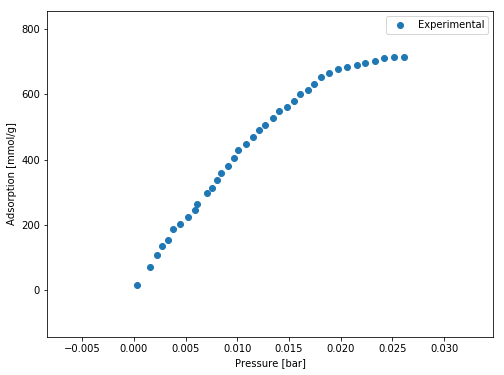

Calculated K = 47458.16999950126
Starting points: 39
Selected points: 8
Final adjusted root mean square difference: 0.006782739634207513


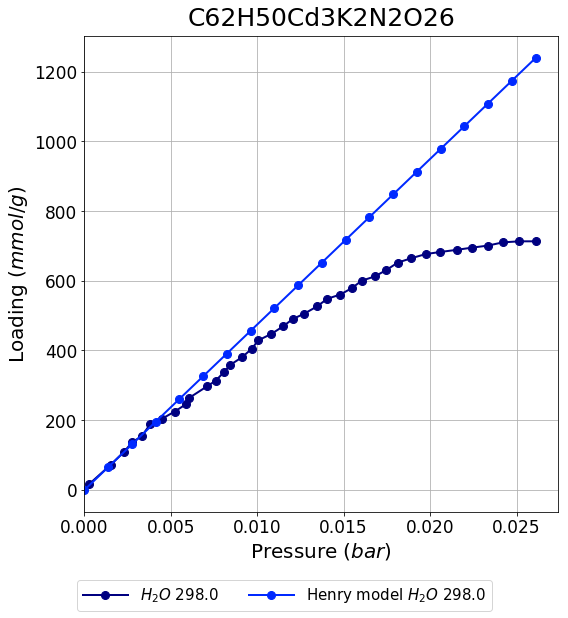

array([0.00028475, 0.00151865, 0.00227797, 0.00275255, 0.00332204,
       0.00379662, 0.00446102, 0.00522035, 0.00588476, 0.00607459,
       0.00711866, 0.00759323, 0.00806781, 0.00844747, 0.00911188,
       0.00968137, 0.010061  , 0.0108204 , 0.0114848 , 0.0120543 ,
       0.0127187 , 0.013478  , 0.0140475 , 0.0148068 , 0.0154712 ,
       0.0160407 , 0.0168    , 0.0174644 , 0.0181288 , 0.0188882 ,
       0.0197424 , 0.0205966 , 0.0215458 , 0.0224    , 0.0233492 ,
       0.0242034 , 0.0251526 , 0.0261017 ])

In [20]:
bad_iso2 = Isotherm('10.1039C3ce26788a.Isotherm1')
bad_iso2.convert_units()
bad_iso2.plot_isotherm()
bad_iso2.pressure = bad_iso2.pressure #* 1e10
bad_iso2.fit_henry_constant(0.01, True)
bad_iso2.add_comment('Created new plot points high KH likely due to water adsorption, paper gives no indication of pressure range used-- is P0 a universal constant-- gas dependent. Extra # of plot points added not similar to lit.', henry_df)
bad_iso2.pressure

In [21]:
bad_iso2.adsorption

array([ 17.16753778,  72.10379189, 108.72770226, 136.19605135,
       154.50828408, 188.08034069, 203.34016457, 224.70425106,
       246.06833754, 264.38057027, 297.95262688, 313.21245076,
       337.62839101, 358.9924775 , 380.35656398, 404.77305931,
       429.18899956, 447.50123229, 468.86531877, 490.22940526,
       505.48922914, 526.85331563, 548.21740212, 560.42426207,
       578.7364948 , 600.10169145, 612.30799632, 630.62022905,
       651.98542571, 664.19173058, 676.40358629, 682.5039633 ,
       688.60989116, 694.71581902, 700.81619603, 709.97508781,
       713.02805174, 713.02805174])

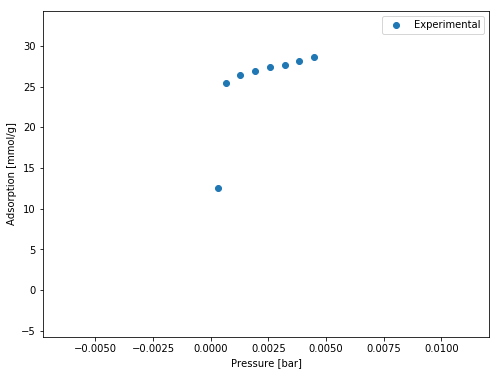

Calculated K = 39207.183846572414
Starting points: 9
Selected points: 3
Final adjusted root mean square difference: 0.0029581313803762987


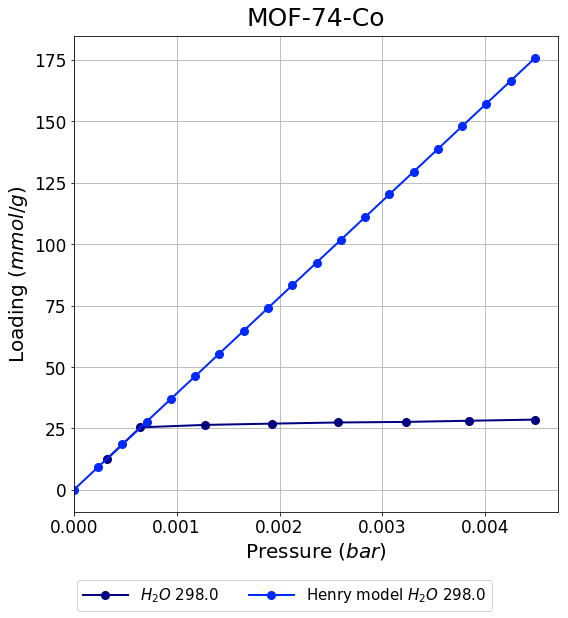

array([0.000324  , 0.000648  , 0.00127627, 0.00192416, 0.00256556,
       0.00322641, 0.0038419 , 0.00448331])

In [22]:
bad_iso2 = Isotherm('10.1016j.ces.2010.10.002.isotherm5')
bad_iso2.convert_units()
bad_iso2.plot_isotherm()
bad_iso2.pressure = bad_iso2.pressure #* 1e10
bad_iso2.fit_henry_constant(0.01, True)
bad_iso2.add_comment('Units converted from RH% at 25C to bar, High KH from water adsorption', henry_df)
bad_iso2.pressure

In [23]:
bad_iso2.adsorption

array([12.57199444, 25.4718217 , 26.4569299 , 26.97293631, 27.44198258,
       27.67656123, 28.14560751, 28.61470929])

[-0.307294  1.83828   4.90338  57.3159   61.2997   24.2112   64.3601
 67.7247   69.5559   71.0806   72.2933   72.592    73.198    73.1933
 73.7883   74.0799   74.3715   74.9688   75.2589   75.2456   75.2291
 75.8272   75.8123   75.7967   76.0859   75.7653   76.0553   76.347
 76.0263  ]


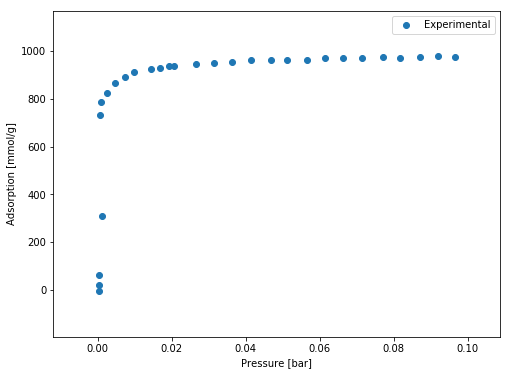

Fitting procedure failed! See `self.error` as to why...


array([0.00025477, 0.00026163, 0.00027143, 0.00069474, 0.00096323,
       0.00110042, 0.00250755, 0.00482009, 0.00738349, 0.00994591,
       0.0142976 , 0.0168561 , 0.0191598 , 0.0206944 , 0.0265786 ,
       0.0314389 , 0.0362991 , 0.0414161 , 0.0467879 , 0.0511357 ,
       0.0565065 , 0.0613677 , 0.066227  , 0.0713421 , 0.0769696 ,
       0.0815721 , 0.0869439 , 0.0918042 , 0.0964067 ])

In [24]:
bad_iso2 = Isotherm('10.1039C3cc48275h.Isotherm20')
print(bad_iso2.adsorption)
bad_iso2.convert_units()
bad_iso2.plot_isotherm()
bad_iso2.pressure = bad_iso2.pressure #* 1e10
bad_iso2.fit_henry_constant(0.01, True)
bad_iso2.add_comment('Fourth point incorrectly plotted by exceeding x-coordinate of two points above its y-coordinate, y-axis in wt% of benzene, negative adsorption', henry_df)
bad_iso2.pressure

In [25]:
bad_iso2.adsorption

array([ -3.93402588,  23.53394825,  62.77383813, 733.7671216 ,
       784.76835266, 309.9555714 , 823.9480724 , 867.02220816,
       890.46551714, 909.98496515, 925.51014033, 929.33414448,
       937.09225132, 937.03208118, 944.6493643 , 948.38247313,
       952.11558197, 959.76231004, 963.47621564, 963.30594696,
       963.09471138, 970.75168118, 970.56092905, 970.36121541,
       974.06359907, 969.95922769, 973.67185308, 977.40624213,
       973.30059054])

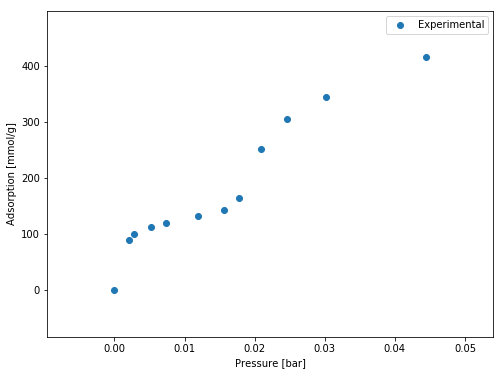

Calculated K = 10655.478497972108
Starting points: 12
Selected points: 12
Final adjusted root mean square difference: 0.10393099340663942


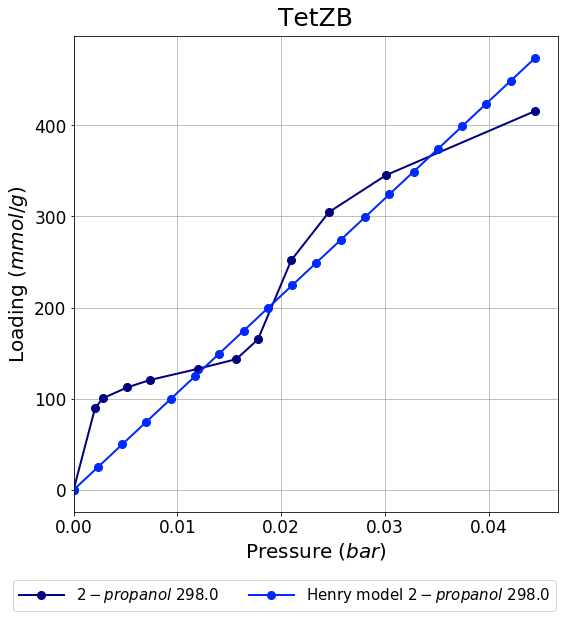

array([0.      , 0.002063, 0.002789, 0.00518 , 0.007363, 0.011939,
       0.015683, 0.01776 , 0.020967, 0.024599, 0.030105, 0.044451])

In [26]:
bad_iso2 = Isotherm('10.1039c5cc00113g.Isotherm5')
bad_iso2.convert_units()
bad_iso2.plot_isotherm()
bad_iso2.pressure = bad_iso2.pressure #* 1e10
bad_iso2.fit_henry_constant(1e100, True)
bad_iso2.add_comment('The adsorption curve shows a sudden increase in uptake at a relative pressure (P/P0) of 0.15 reaching the first saturation capacity of 7.8 wt%. At a relative pressure (P/P0) of 0.27, TetZB shows another step adsorption reaching the second saturation capacity of 26 wt% or 4.55 mmol g−1-- Units for adsorption may be converted incorrectly.', henry_df)
bad_iso2.pressure

In [27]:
bad_iso2.adsorption

array([  0.        ,  89.48528514, 100.32112478, 112.4758757 ,
       120.56556433, 132.67056072, 143.43784227, 165.09537729,
       251.84116754, 304.66418016, 345.23659365, 415.45039839])

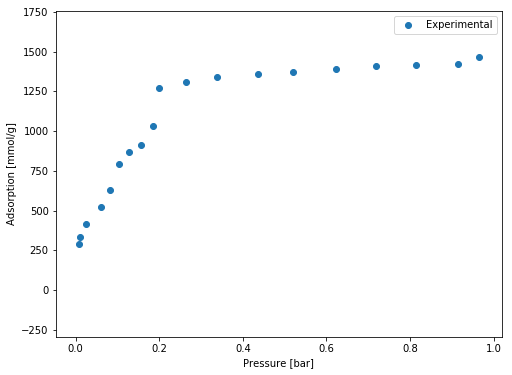

Calculated K = 2121.5957835685113
Starting points: 20
Selected points: 20
Final adjusted root mean square difference: 0.33279640380830866


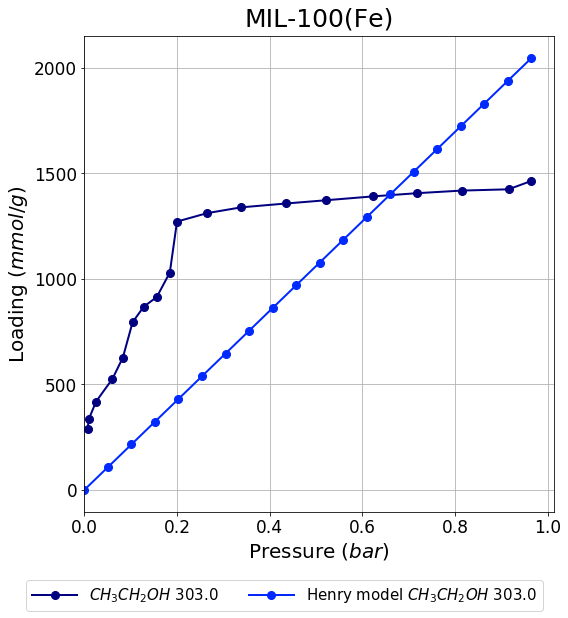

array([0.00702701, 0.00984391, 0.0253369 , 0.0605481 , 0.0830833 ,
       0.10421   , 0.128154  , 0.156323  , 0.184492  , 0.199985  ,
       0.264773  , 0.338013  , 0.435196  , 0.521111  , 0.62252   ,
       0.718295  , 0.814069  , 0.915478  , 0.964773  ])

In [28]:
bad_iso2 = Isotherm('10.1016j.micromeso.2012.02.027.isotherm5')
bad_iso2.convert_units()
bad_iso2.plot_isotherm()
bad_iso2.pressure = bad_iso2.pressure #* 1e10
bad_iso2.fit_henry_constant(1e100, True)
bad_iso2.add_comment('Ethanol yields three-step isotherms, with two step isotherms at very low p/p0., # of plot points do not correspond with literature,-- not sure if MIL-100(Fe)_F or MIL-100(Fe)_NF7 ', henry_df)
bad_iso2.pressure

In [29]:
bad_iso2.adsorption

array([ 290.47651711,  336.33654623,  418.88329624,  525.8893073 ,
        626.78050309,  794.9303254 ,  868.30593786,  914.16596698,
       1030.34311559, 1271.87072104, 1311.6159349 , 1339.13151824,
       1357.47379334, 1372.76191684, 1391.10419194, 1406.39231543,
       1418.61977527, 1424.73459054, 1464.4798044 ])

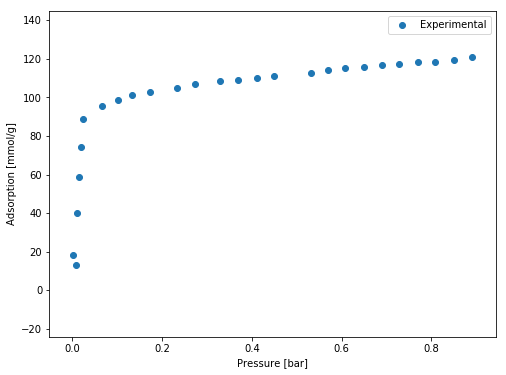

Calculated K = 185.6267901240829
Starting points: 27
Selected points: 27
Final adjusted root mean square difference: 0.38956714137808274


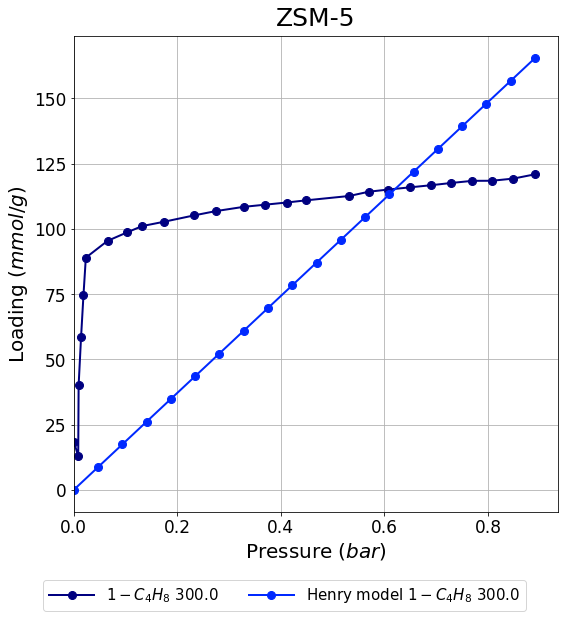

array([5.38402e-04, 8.70807e-03, 9.50397e-03, 1.42091e-02, 1.88441e-02,
       2.34322e-02, 6.52871e-02, 1.02882e-01, 1.32119e-01, 1.73834e-01,
       2.32239e-01, 2.73953e-01, 3.28168e-01, 3.69859e-01, 4.11550e-01,
       4.49074e-01, 5.32456e-01, 5.70004e-01, 6.07528e-01, 6.49219e-01,
       6.90910e-01, 7.28435e-01, 7.70126e-01, 8.07627e-01, 8.49318e-01,
       8.91032e-01])

In [30]:
bad_iso2 = Isotherm('10.1016S1004-9541(07)60095-0.Isotherm10-1')
bad_iso2.convert_units()
bad_iso2.plot_isotherm()
bad_iso2.pressure = bad_iso2.pressure #* 1e10
bad_iso2.fit_henry_constant(1e100, True)
bad_iso2.add_comment('Second plot point not linear on x-coordinate, literature indicates different ZSM-5 samples, but no way to determine which curve was used. Additionally, literature indicates mmol g-1, but .json indicates wt%. ', henry_df)
bad_iso2.pressure

In [31]:
bad_iso2.adsorption

array([ 18.42448409,  12.82372467,  40.06001463,  58.48788514,
        74.51246134,  88.93507897,  95.37695575,  98.6111725 ,
       101.03781535, 102.67328173, 105.1232731 , 106.75873948,
       108.40418691, 109.238674  , 110.0731611 , 110.90426177,
       112.57323596, 114.20531591, 115.03641657, 115.87090367,
       116.70539077, 117.53649143, 118.37080029, 118.40092168,
       119.23540877, 120.87087515])

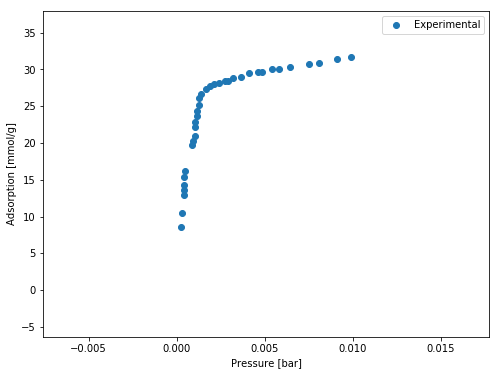

Calculated K = 5372.446108593179
Starting points: 36
Selected points: 36
Final adjusted root mean square difference: 0.43244806647288087


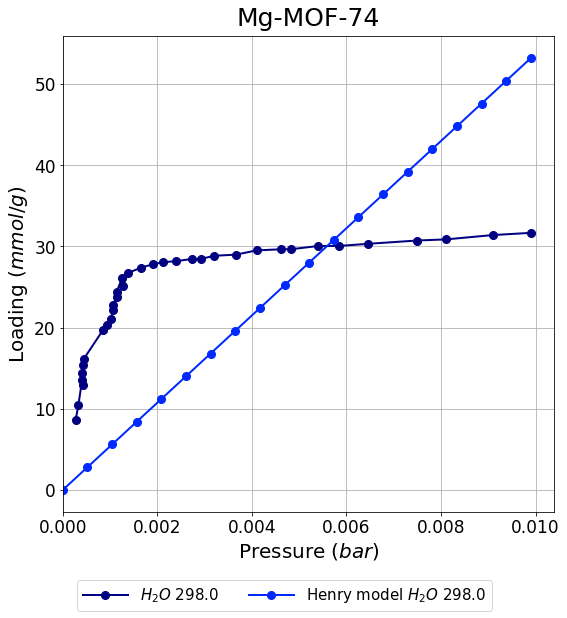

array([0.00027128, 0.0003294 , 0.00040723, 0.0004076 , 0.000426  ,
       0.00042719, 0.00044664, 0.00084909, 0.00092573, 0.00102146,
       0.00106019, 0.0010605 , 0.00113727, 0.00113759, 0.0012529 ,
       0.00127155, 0.0013868 , 0.00165429, 0.00190257, 0.00211261,
       0.00239894, 0.00272349, 0.00291433, 0.00320078, 0.00365886,
       0.00409804, 0.00461338, 0.0048233 , 0.00539601, 0.00583494,
       0.00646484, 0.00749557, 0.00810632, 0.00909895, 0.0099006 ])

In [32]:
bad_iso2 = Isotherm('10.1021Ct500094w.Isotherm4')
bad_iso2.convert_units()
bad_iso2.plot_isotherm()
bad_iso2.pressure = bad_iso2.pressure #* 1e10
bad_iso2.fit_henry_constant(1e100, True)
bad_iso2.add_comment('Large KH likely due to water adsorption', henry_df)
bad_iso2.pressure

In [33]:
bad_iso2.adsorption

array([ 8.60288, 10.4277 , 13.5558 , 14.3376 , 12.9046 , 15.3802 ,
       16.1622 , 19.6853 , 20.3378 , 20.9905 , 22.1637 , 22.8151 ,
       23.7282 , 24.3796 , 26.075  , 25.1631 , 26.7282 , 27.3831 ,
       27.7772 , 28.0406 , 28.1746 , 28.4394 , 28.4419 , 28.8365 ,
       28.9728 , 29.4996 , 29.6367 , 29.6394 , 30.0377 , 30.0435 ,
       30.3122 , 30.7166 , 30.8548 , 31.3889 , 31.6599 ])

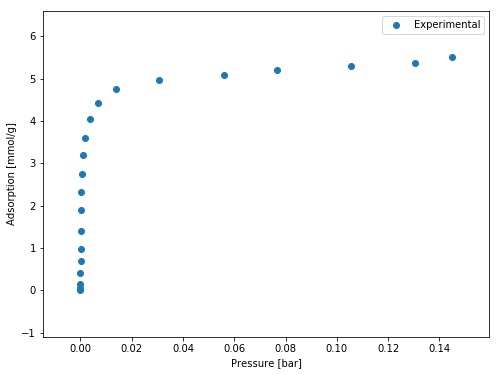

Calculated K = 50.786448413029866
Starting points: 23
Selected points: 23
Final adjusted root mean square difference: 0.4030692025726425


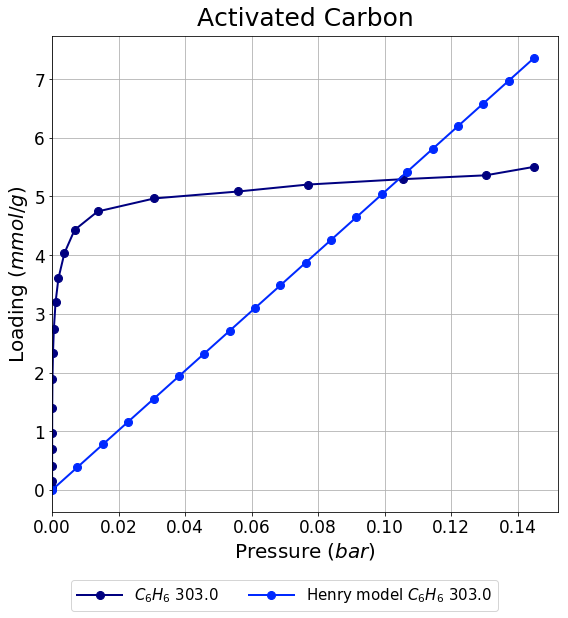

array([4.21000e-07, 9.81000e-07, 1.72000e-06, 5.91000e-06, 1.00000e-05,
       1.76000e-05, 2.59000e-05, 4.72000e-05, 1.10000e-04, 2.75000e-04,
       5.36000e-04, 1.04673e-03, 1.90473e-03, 3.71897e-03, 6.76741e-03,
       1.36869e-02, 3.07659e-02, 5.59848e-02, 7.68629e-02, 1.05527e-01,
       1.30355e-01, 1.44881e-01])

In [34]:
bad_iso2 = Isotherm('10.1021la010232r.Isotherm1')
bad_iso2.convert_units()
bad_iso2.plot_isotherm()
bad_iso2.pressure = bad_iso2.pressure #* 1e10
bad_iso2.fit_henry_constant(1e100, True)
bad_iso2.add_comment('Original literature in log scale and pascals. Not sure what is wrong', henry_df)
bad_iso2.pressure

In [35]:
bad_iso2.adsorption

array([0.0112343, 0.0243436, 0.0505621, 0.155436 , 0.404512 , 0.692915 ,
       0.968209 , 1.40081  , 1.88586  , 2.33157  , 2.73796  , 3.19678  ,
       3.60317  , 4.03577  , 4.42905  , 4.74367  , 4.96653  , 5.08451  ,
       5.20249  , 5.29426  , 5.35981  , 5.50401  ])

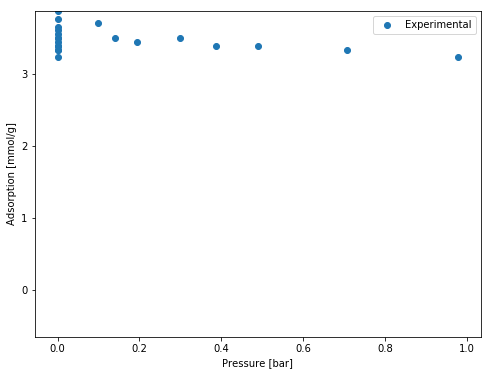

Calculated K = 6.045333734943599
Starting points: 40
Selected points: 40
Final adjusted root mean square difference: 0.7664930430326092


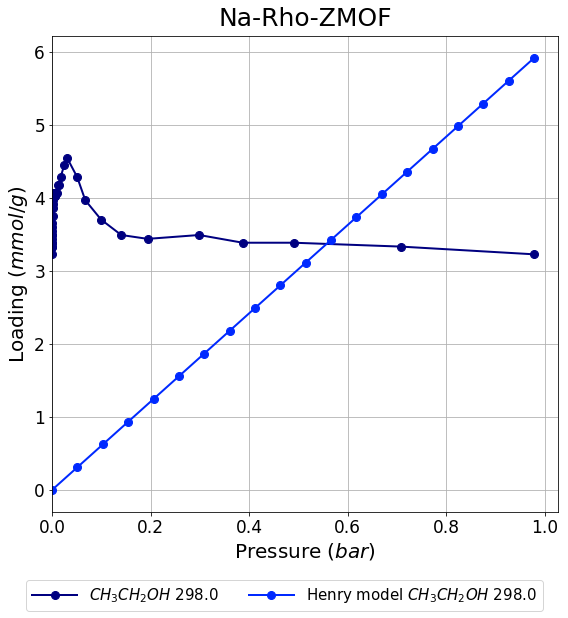

array([1.02181e-04, 1.13818e-04, 1.41215e-04, 1.75210e-04, 2.17390e-04,
       2.69718e-04, 3.27507e-04, 4.06350e-04, 5.04173e-04, 6.25533e-04,
       7.76122e-04, 9.42410e-04, 1.11990e-03, 1.35985e-03, 1.68721e-03,
       1.87932e-03, 2.23332e-03, 2.77089e-03, 3.43795e-03, 4.26560e-03,
       5.29237e-03, 6.56644e-03, 7.97333e-03, 9.68166e-03, 1.15051e-02,
       1.42748e-02, 1.73333e-02, 2.44771e-02, 3.03697e-02, 5.09636e-02,
       6.74590e-02, 9.94626e-02, 1.40456e-01, 1.94114e-01, 2.98820e-01,
       3.87099e-01, 4.90758e-01, 7.08137e-01, 9.78661e-01])

In [36]:
bad_iso2 = Isotherm('10.1021Jp1033273.Isotherm16')
bad_iso2.convert_units()
bad_iso2.plot_isotherm()
bad_iso2.pressure = bad_iso2.pressure #* 1e10
bad_iso2.fit_henry_constant(1e100, True)
bad_iso2.add_comment('Plot likely taken from fig. 5 adsorption isotherms for equimolar mixtures of water/ethanol while on a log scale', henry_df)
bad_iso2.pressure

In [37]:
bad_iso2.adsorption

array([3.22751, 3.33333, 3.33333, 3.38624, 3.38624, 3.43915, 3.49206,
       3.49206, 3.54497, 3.59788, 3.65079, 3.75661, 3.86243, 3.91534,
       3.96825, 4.07407, 4.07407, 4.02116, 4.02116, 4.02116, 4.02116,
       4.02116, 4.07407, 4.07407, 4.17989, 4.17989, 4.28571, 4.44444,
       4.55026, 4.28571, 3.96825, 3.7037 , 3.49206, 3.43915, 3.49206,
       3.38624, 3.38624, 3.33333, 3.22751])

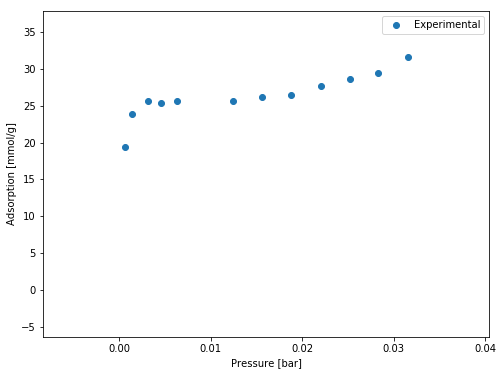

Calculated K = 1279.087891674876
Starting points: 13
Selected points: 13
Final adjusted root mean square difference: 0.4173514667296537


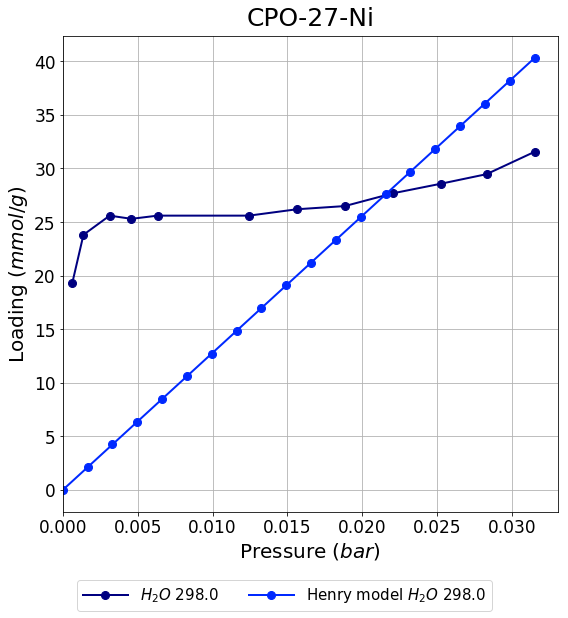

array([0.00063807, 0.0013783 , 0.00312889, 0.00458251, 0.00632877,
       0.0124376 , 0.0156392 , 0.01884   , 0.0220433 , 0.0252458 ,
       0.0283028 , 0.0315087 ])

In [38]:
bad_iso2 = Isotherm('10.1039C4cs00078a.Isotherm3')
bad_iso2.convert_units()
bad_iso2.plot_isotherm()
bad_iso2.pressure = bad_iso2.pressure #* 1e10
bad_iso2.fit_henry_constant(1e100, True)
bad_iso2.add_comment('Original lit. units in PH2O/PsatH2O. High KH likely due to water adsorption', henry_df)
bad_iso2.pressure

In [39]:
bad_iso2.adsorption

array([19.3452, 23.8095, 25.5952, 25.2976, 25.5952, 25.5952, 26.1905,
       26.4881, 27.6786, 28.5714, 29.4643, 31.5476])

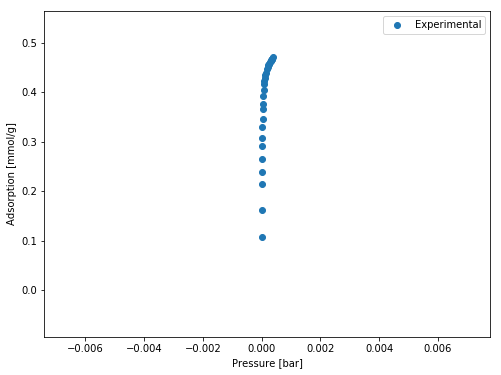

Calculated K = 1742.45881866266
Starting points: 31
Selected points: 31
Final adjusted root mean square difference: 0.43195805362813816


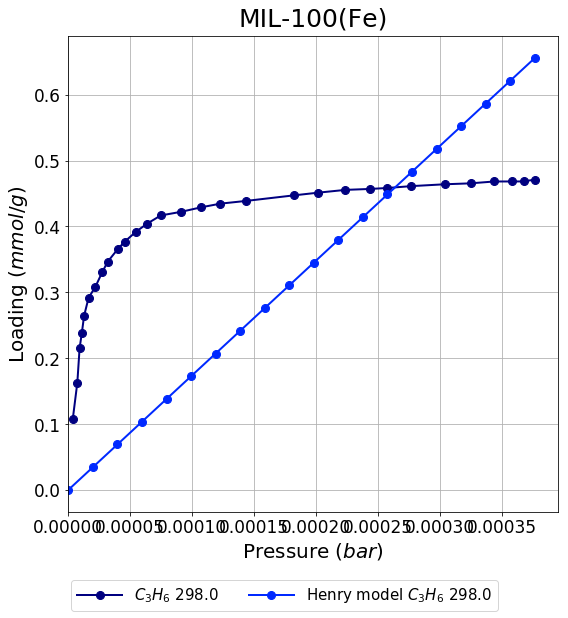

array([3.63606e-06, 7.27214e-06, 9.09016e-06, 1.09082e-05, 1.27262e-05,
       1.63623e-05, 2.18163e-05, 2.72704e-05, 3.18155e-05, 3.99967e-05,
       4.54508e-05, 5.45410e-05, 6.36312e-05, 7.45393e-05, 9.09016e-05,
       1.07264e-04, 1.22717e-04, 1.43624e-04, 1.81804e-04, 2.01802e-04,
       2.23618e-04, 2.43616e-04, 2.57252e-04, 2.76341e-04, 3.03611e-04,
       3.24519e-04, 3.43608e-04, 3.58152e-04, 3.67243e-04, 3.76333e-04])

In [40]:
bad_iso2 = Isotherm('10.1039C1cp20502a.Isotherm5')
bad_iso2.convert_units()
bad_iso2.plot_isotherm()
bad_iso2.pressure = bad_iso2.pressure #* 1e10
bad_iso2.fit_henry_constant(1e100, True)
bad_iso2.add_comment('Cant find the propene adsorption isotherm in the literature. I believe this may be from the propyne isotherm adsorption. Original units are in torr and isotherm was measured during extremely low pressure (0-0.3 torr)', henry_df)
bad_iso2.pressure

In [41]:
bad_iso2.adsorption

array([0.108232, 0.163039, 0.2151  , 0.238394, 0.264427, 0.291837,
       0.308294, 0.33023 , 0.346684, 0.36589 , 0.376868, 0.391968,
       0.404328, 0.416694, 0.422229, 0.429134, 0.434667, 0.438848,
       0.447198, 0.451376, 0.45556 , 0.456999, 0.458415, 0.46122 ,
       0.464054, 0.465495, 0.4683  , 0.46835 , 0.468381, 0.471152])

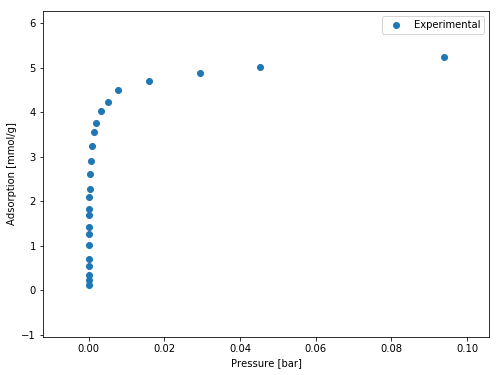

Calculated K = 85.03553097586794
Starting points: 25
Selected points: 25
Final adjusted root mean square difference: 0.45159607756312903


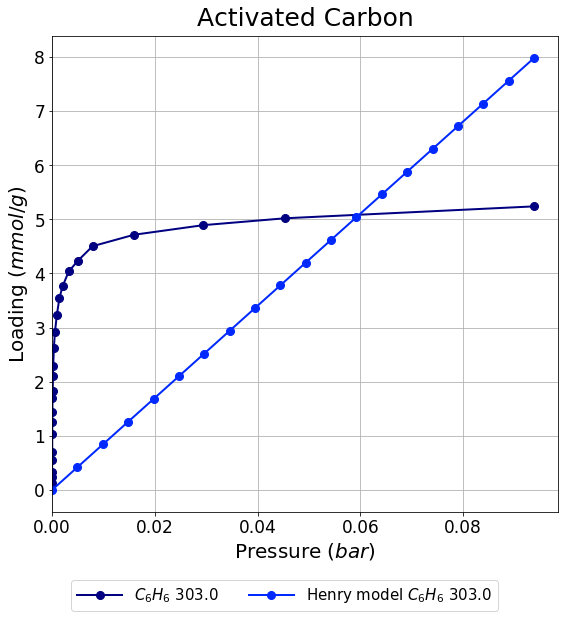

array([1.80000e-06, 4.46000e-06, 7.19000e-06, 1.36000e-05, 2.45000e-05,
       3.53000e-05, 4.43000e-05, 6.09000e-05, 8.18000e-05, 1.23000e-04,
       1.73000e-04, 2.22000e-04, 3.42000e-04, 5.52000e-04, 9.30000e-04,
       1.43297e-03, 2.06137e-03, 3.24753e-03, 5.00126e-03, 7.87910e-03,
       1.59383e-02, 2.94393e-02, 4.53372e-02, 9.38189e-02])

In [42]:
bad_iso2 = Isotherm('10.1021la010232r.Isotherm3')
bad_iso2.convert_units()
bad_iso2.plot_isotherm()
bad_iso2.pressure = bad_iso2.pressure #* 1e10
bad_iso2.fit_henry_constant(1e100, True)
bad_iso2.add_comment('Original literature in log scale and pascals. There are two isotherms measuring the same mof and adsorbent at same temp (10.1021la010232r.Isotherm1) Not sure what is wrong', henry_df)
bad_iso2.pressure

In [43]:
bad_iso2.adsorption

array([0.119506, 0.237944, 0.331003, 0.550959, 0.694777, 1.02471 ,
       1.26159 , 1.43079 , 1.7015  , 1.8284  , 2.09912 , 2.28523 ,
       2.61517 , 2.91126 , 3.23274 , 3.54575 , 3.76571 , 4.03643 ,
       4.231   , 4.50172 , 4.71322 , 4.89087 , 5.01777 , 5.23773 ])

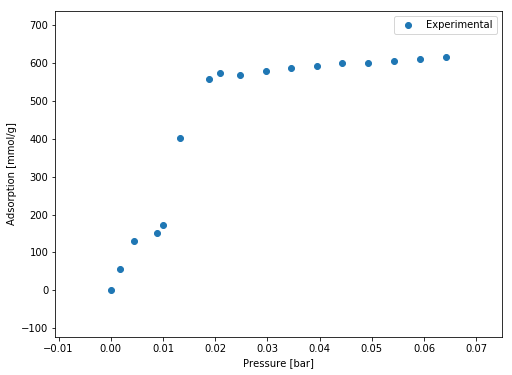

Calculated K = 13321.527648282869
Starting points: 17
Selected points: 17
Final adjusted root mean square difference: 0.2677775842703579


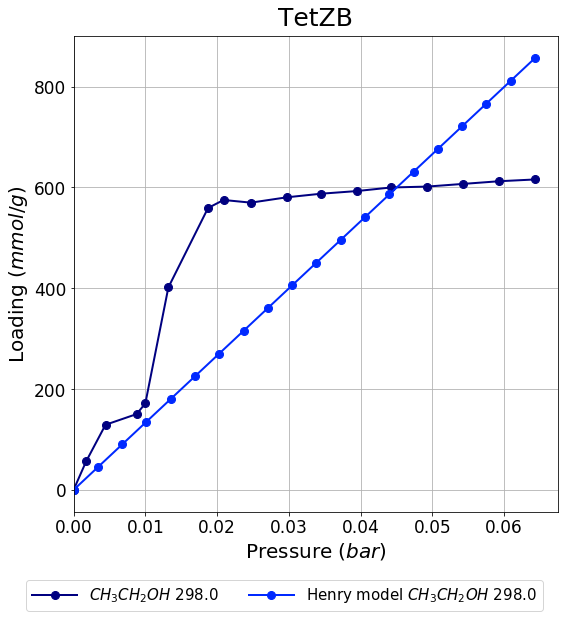

array([0.      , 0.001752, 0.00445 , 0.008786, 0.010002, 0.01321 ,
       0.018739, 0.020906, 0.024706, 0.029723, 0.034469, 0.039487,
       0.044233, 0.049252, 0.05427 , 0.059288, 0.064306])

In [44]:
bad_iso2 = Isotherm('10.1039c5cc00113g.Isotherm1')
bad_iso2.convert_units()
bad_iso2.plot_isotherm()
bad_iso2.pressure = bad_iso2.pressure #* 1e10
bad_iso2.fit_henry_constant(1e100, True)
bad_iso2.add_comment('P/P0 scale on the same plot. Wt% on y axis', henry_df)
bad_iso2.pressure

In [45]:
bad_iso2.adsorption

array([  0.        ,  56.626619  , 129.17932537, 150.41425323,
       171.64918109, 401.69365405, 559.18759133, 575.11389576,
       569.80440406, 580.42121678, 587.49981549, 592.8093072 ,
       599.88790591, 601.65701291, 606.96650462, 612.27382564,
       615.81421034])

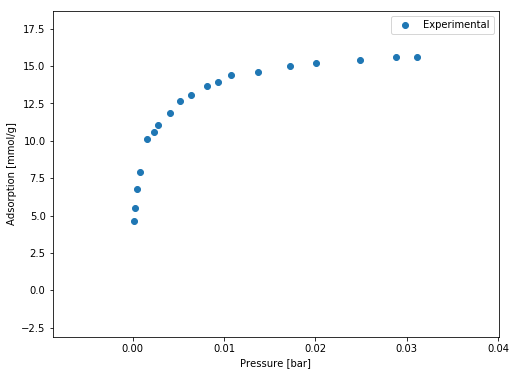

Calculated K = 749.7077013846084
Starting points: 20
Selected points: 20
Final adjusted root mean square difference: 0.42571905896055284


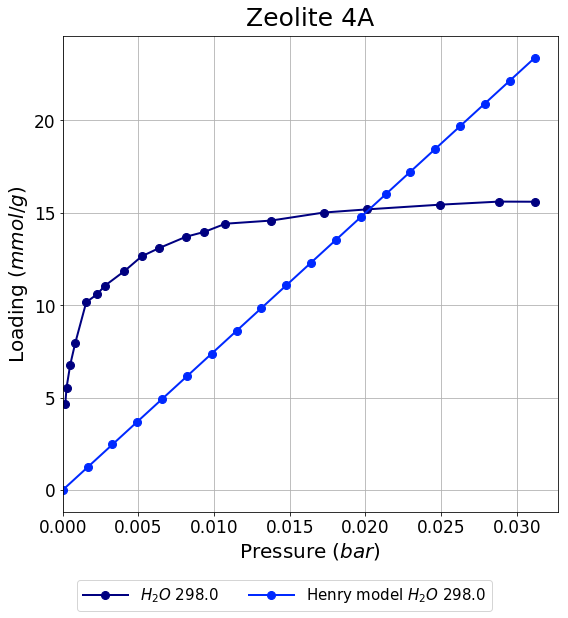

array([0.00016278, 0.00024417, 0.00048835, 0.00081391, 0.00154643,
       0.00227895, 0.0027673 , 0.00406956, 0.00520904, 0.00634851,
       0.00813912, 0.00935999, 0.0107436 , 0.0137551 , 0.0172549 ,
       0.0201036 , 0.0249057 , 0.0288125 , 0.0311728 ])

In [46]:
bad_iso2 = Isotherm('10.1021Jp805923k.Isotherm2')
bad_iso2.convert_units()
bad_iso2.plot_isotherm()
bad_iso2.pressure = bad_iso2.pressure #* 1e10
bad_iso2.fit_henry_constant(1e100, True)
bad_iso2.add_comment('Water adsorption, on P/Psat scale', henry_df)
bad_iso2.pressure

In [47]:
bad_iso2.adsorption

array([ 4.6332 ,  5.52406,  6.77089,  7.92838, 10.154  , 10.5975 ,
       11.0417 , 11.8399 , 12.6387 , 13.081  , 13.6997 , 13.9636 ,
       14.4052 , 14.5748 , 15.0105 , 15.1806 , 15.4343 , 15.6014 ,
       15.5948 ])

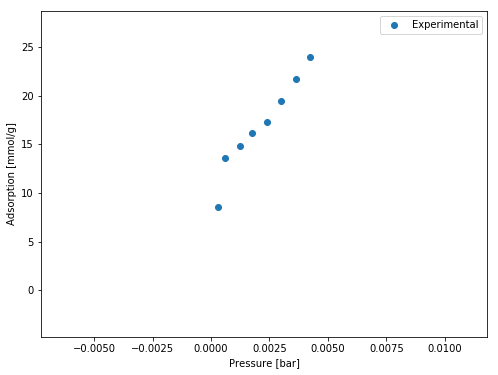

Calculated K = 6634.744720015637
Starting points: 9
Selected points: 9
Final adjusted root mean square difference: 0.20750690137041147


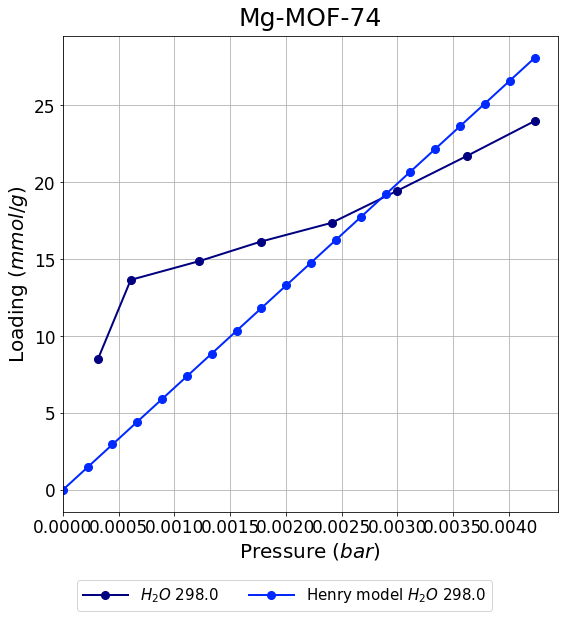

array([0.000317  , 0.000609  , 0.00122444, 0.00177514, 0.00241007,
       0.00299317, 0.0036281 , 0.00423063])

In [48]:
bad_iso2 = Isotherm('10.1016j.ces.2010.10.002.isotherm6')
bad_iso2.convert_units()
bad_iso2.plot_isotherm()
bad_iso2.pressure = bad_iso2.pressure #* 1e10
bad_iso2.fit_henry_constant(1e100, True)
bad_iso2.add_comment('x axis measured with relative humidity, water adsorption', henry_df)
bad_iso2.pressure

In [49]:
bad_iso2.adsorption

array([ 8.53786341, 13.65091189, 14.87048772, 16.13702368, 17.35665502,
       19.42062516, 21.71917395, 23.9707626 ])

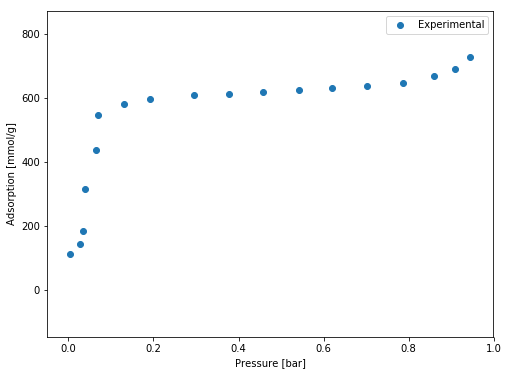

Calculated K = 955.3856830125795
Starting points: 19
Selected points: 19
Final adjusted root mean square difference: 0.34465784134237776


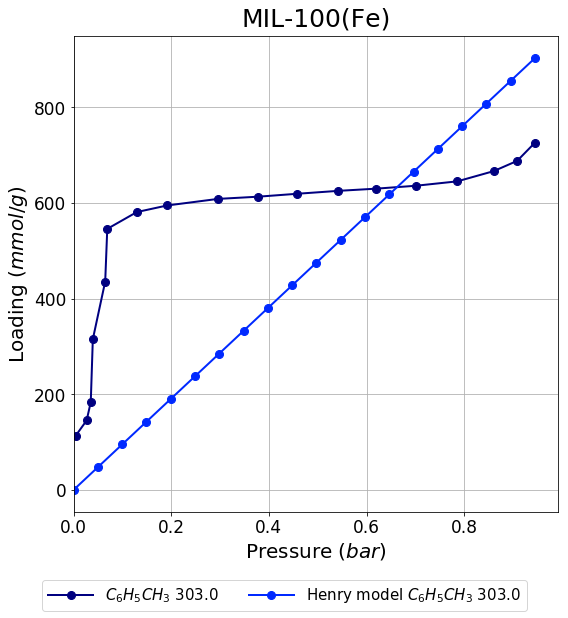

array([0.00421011, 0.0267453 , 0.035196  , 0.0394214 , 0.0647735 ,
       0.0689988 , 0.129562  , 0.191534  , 0.295759  , 0.37745   ,
       0.457731  , 0.542238  , 0.619703  , 0.701393  , 0.7859    ,
       0.860548  , 0.908435  , 0.945055  ])

In [50]:
bad_iso2 = Isotherm('10.1016j.micromeso.2012.02.027.isotherm8')
bad_iso2.convert_units()
bad_iso2.plot_isotherm()
bad_iso2.pressure = bad_iso2.pressure #* 1e10
bad_iso2.fit_henry_constant(1e100, True)
bad_iso2.add_comment('Does not include same number of data points as literature. P/P0 scale', henry_df)
bad_iso2.pressure

In [51]:
bad_iso2.adsorption

array([113.13521547, 145.23583105, 183.45115968, 314.91314915,
       435.67493343, 545.7354272 , 580.89448462, 594.65204635,
       608.40960807, 612.9951002 , 619.10981326, 625.22452632,
       629.81001845, 635.92473151, 645.09571577, 666.49721148,
       687.89762186, 726.11295049])

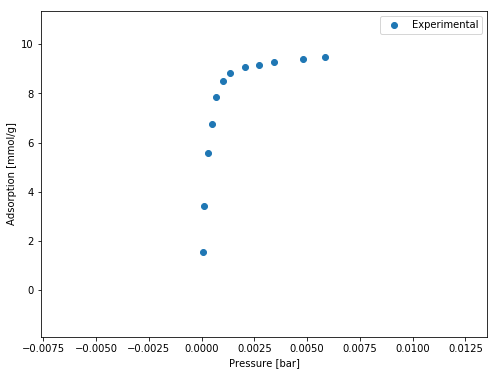

C:\Users\Owner\Anaconda3\lib\site-packages\pygaps\classes\isotherm.py:186: UserWarning: Specified adsorbent is not in internal list(or name cannot be resolved to an existing one).CoolProp backend disabled for this adsorbent.
  ("Specified adsorbent is not in internal list"


Calculated K = 2458.8767193956055
Starting points: 13
Selected points: 13
Final adjusted root mean square difference: 0.43758312194865756


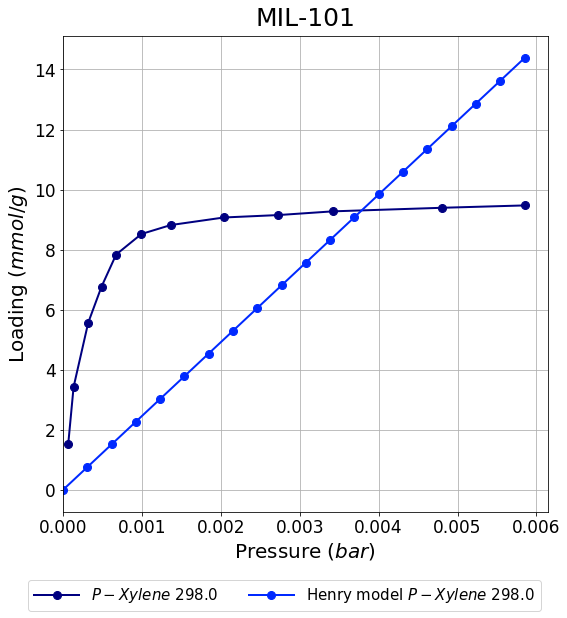

array([6.74000e-05, 1.34831e-04, 3.20225e-04, 4.88764e-04, 6.74157e-04,
       9.94382e-04, 1.36517e-03, 2.03933e-03, 2.73034e-03, 3.42135e-03,
       4.80337e-03, 5.84831e-03])

In [52]:
bad_iso2 = Isotherm('10.1016j.cej.2011.07.051.Isotherm3')
bad_iso2.convert_units()
bad_iso2.plot_isotherm()
bad_iso2.pressure = bad_iso2.pressure #* 1e10
bad_iso2.fit_henry_constant(1e100, True)
bad_iso2.add_comment('"The high regression coefficient R2 up to 0.997 indicates that the L-F model gives a good fit to the experimental isotherm of p-xylene on the MIL-101 samples. At low adsorbate concentrations the L-F model can effectively reduce to a Freundlich isotherm and thus does not obey Henrys law.-- solid curves, model fitting by Langmuir-Fruendlich equation)."', henry_df)
bad_iso2.pressure

In [53]:
bad_iso2.adsorption

array([1.54238, 3.42761, 5.56914, 6.76794, 7.83804, 8.52147, 8.81882,
       9.07115, 9.15193, 9.27556, 9.39426, 9.47251])

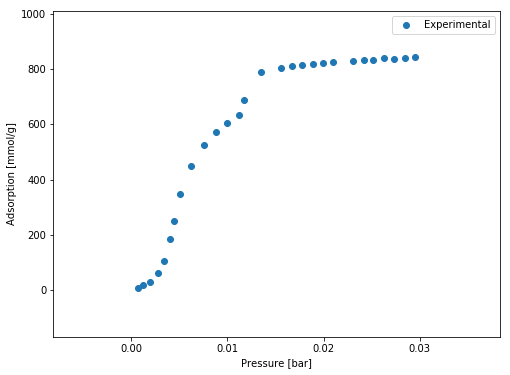

Calculated K = 37849.641675525985
Starting points: 29
Selected points: 29
Final adjusted root mean square difference: 0.19178576532902664


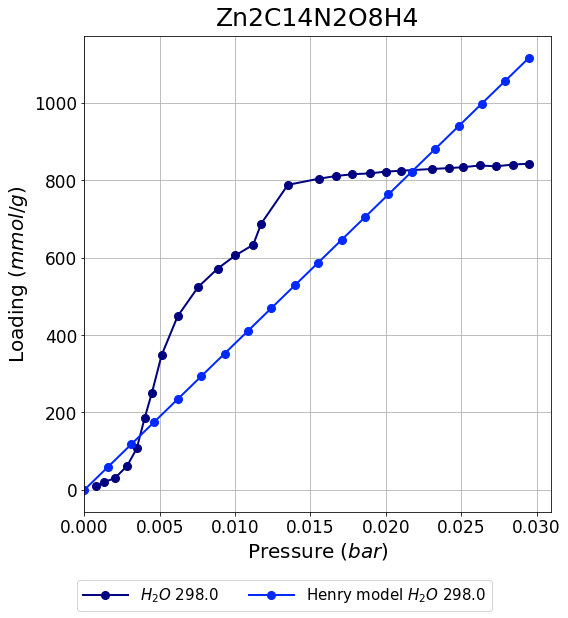

array([0.00076627, 0.00129676, 0.00200409, 0.0028293 , 0.00347768,
       0.00400817, 0.00447972, 0.0051281 , 0.00618909, 0.0075448 ,
       0.00884156, 0.0100204 , 0.0111993 , 0.0117298 , 0.0134981 ,
       0.0155611 , 0.0166811 , 0.0177421 , 0.0189209 , 0.0199819 ,
       0.020984  , 0.023047  , 0.0241669 , 0.02511   , 0.02623   ,
       0.0272909 , 0.0284109 , 0.0294719 ])

In [54]:
bad_iso2 = Isotherm('10.1021Ja060946u.Isotherm11')
bad_iso2.convert_units()
bad_iso2.plot_isotherm()
bad_iso2.pressure = bad_iso2.pressure #* 1e10
bad_iso2.fit_henry_constant(1e100, True)
bad_iso2.add_comment('P/P0 scale, water adsorption', henry_df)
bad_iso2.pressure

In [55]:
bad_iso2.adsorption

array([  9.10910072,  20.49543499,  29.6044802 ,  61.48613843,
       107.03191957, 186.73592639, 250.49957592, 348.42200621,
       448.62194759, 523.7720424 , 571.59255921, 605.75245014,
       633.07925272, 687.73285789, 787.93668486, 803.87870741,
       810.70624492, 815.26348744, 817.53933328, 822.0965758 ,
       824.37242163, 828.92411331, 831.20550999, 833.48135583,
       838.0330475 , 835.75720166, 840.31444418, 842.59029002])

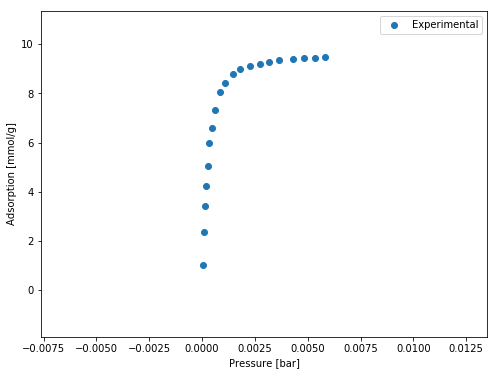

Calculated K = 2411.7985391828665
Starting points: 21
Selected points: 21
Final adjusted root mean square difference: 0.41316732337849915


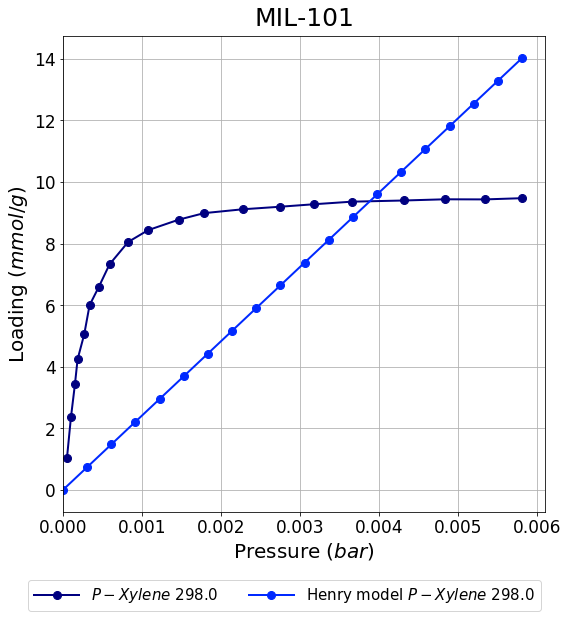

array([5.06000e-05, 1.01124e-04, 1.51685e-04, 1.85393e-04, 2.69663e-04,
       3.37079e-04, 4.55056e-04, 5.89888e-04, 8.25843e-04, 1.07865e-03,
       1.46629e-03, 1.78652e-03, 2.27528e-03, 2.74719e-03, 3.18539e-03,
       3.65730e-03, 4.31461e-03, 4.83708e-03, 5.34270e-03, 5.81461e-03])

In [56]:
bad_iso2 = Isotherm('10.1016j.cej.2011.07.051.Isotherm3-1')
bad_iso2.convert_units()
bad_iso2.plot_isotherm()
bad_iso2.pressure = bad_iso2.pressure #* 1e10
bad_iso2.fit_henry_constant(1e100, True)
bad_iso2.add_comment('"The high regression coefficient R2 up to 0.997 indicates that the L-F model gives a good fit to the experimental isotherm of p-xylene on the MIL-101 samples. At low adsorbate concentrations the L-F model can effectively reduce to a Freundlich isotherm and thus does not obey Henrys law.-- solid curves, model fitting by Langmuir-Fruendlich equation).', henry_df)
bad_iso2.pressure

In [57]:
bad_iso2.adsorption

array([1.02821, 2.35642, 3.42749, 4.24153, 5.05522, 5.99759, 6.59675,
       7.32436, 8.05124, 8.43515, 8.77524, 8.98724, 9.11232, 9.19466,
       9.27725, 9.35959, 9.39775, 9.43688, 9.43327, 9.47275])

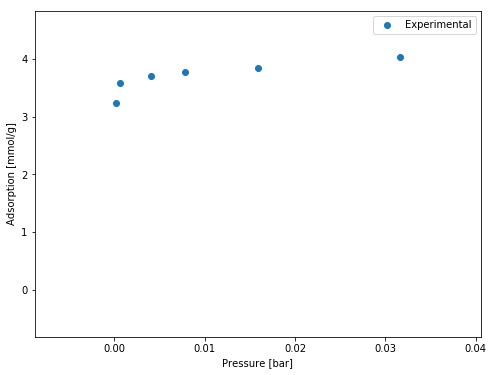

Calculated K = 176.81532418455853
Starting points: 7
Selected points: 7
Final adjusted root mean square difference: 0.5968300810755528


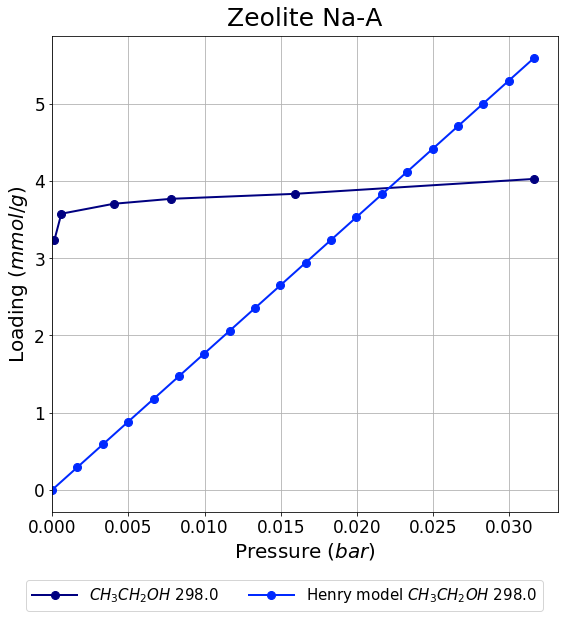

array([0.000149  , 0.000607  , 0.00403898, 0.00781456, 0.0159378 ,
       0.0316121 ])

In [58]:
bad_iso2 = Isotherm('10.1252Jcej.37.67.isotherm4')
bad_iso2.convert_units()
bad_iso2.plot_isotherm()
bad_iso2.pressure = bad_iso2.pressure #* 1e10
bad_iso2.fit_henry_constant(1e100, True)
bad_iso2.add_comment('Extremely steep initial slope', henry_df)
bad_iso2.pressure

In [59]:
bad_iso2.adsorption

array([3.23126, 3.57449, 3.7032 , 3.76756, 3.83192, 4.02498])

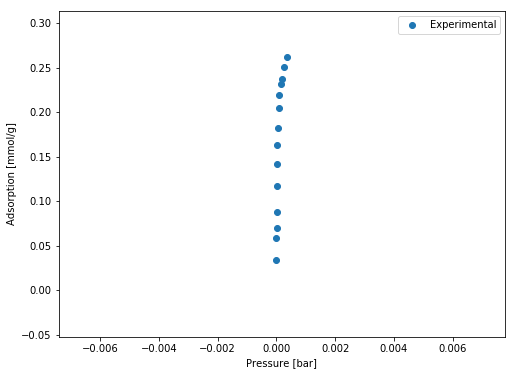

Calculated K = 1055.1978122043845
Starting points: 15
Selected points: 15
Final adjusted root mean square difference: 0.3537512367546034


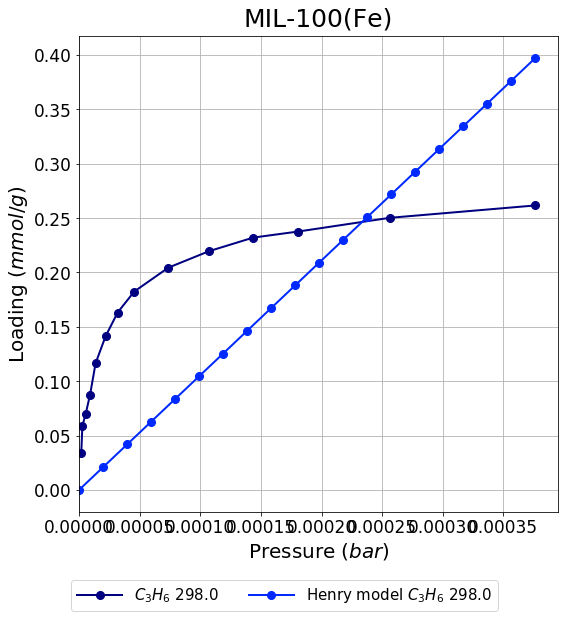

array([1.81804e-06, 2.72704e-06, 5.45410e-06, 9.09016e-06, 1.36353e-05,
       2.18163e-05, 3.18155e-05, 4.54508e-05, 7.36303e-05, 1.07264e-04,
       1.43624e-04, 1.80894e-04, 2.56343e-04, 3.76333e-04])

In [60]:
bad_iso2 = Isotherm('10.1039C1cp20502a.Isotherm6')
bad_iso2.convert_units()
bad_iso2.plot_isotherm()
bad_iso2.pressure = bad_iso2.pressure #* 1e10
bad_iso2.fit_henry_constant(1e100, True)
bad_iso2.add_comment('Incredibily low pressure data points only', henry_df)
bad_iso2.pressure

In [61]:
bad_iso2.adsorption

array([0.0342528, 0.0589134, 0.0698817, 0.0877024, 0.116485 , 0.141171 ,
       0.163123 , 0.182347 , 0.204362 , 0.219545 , 0.231999 , 0.237606 ,
       0.250193 , 0.261563 ])

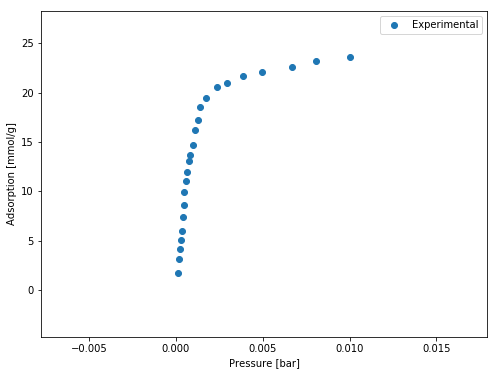

Calculated K = 3777.28792432865
Starting points: 25
Selected points: 25
Final adjusted root mean square difference: 0.37144306147940054


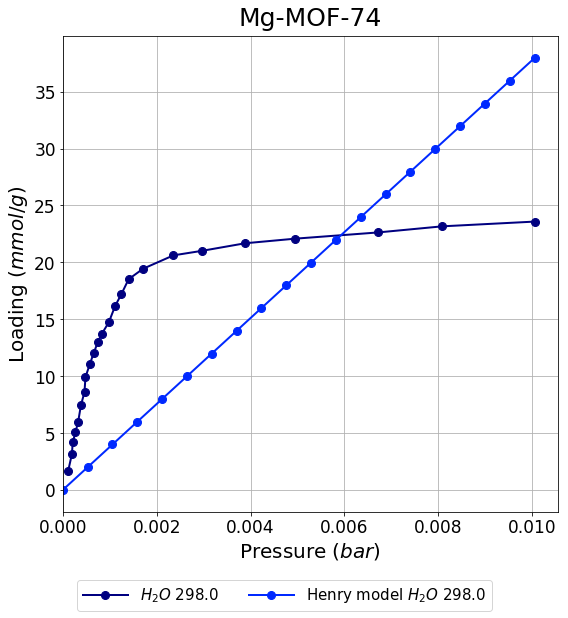

array([0.00011531, 0.00019233, 0.00021191, 0.0002696 , 0.00032729,
       0.00038522, 0.00046212, 0.00048183, 0.00057781, 0.00065458,
       0.0007505 , 0.00082714, 0.00098031, 0.00111459, 0.00124867,
       0.00140197, 0.00170775, 0.00235716, 0.00296804, 0.00388439,
       0.00495328, 0.00670927, 0.00808357, 0.0100494 ])

In [62]:
bad_iso2 = Isotherm('10.1021Ct500094w.Isotherm5')
bad_iso2.convert_units()
bad_iso2.plot_isotherm()
bad_iso2.pressure = bad_iso2.pressure #* 1e10
bad_iso2.fit_henry_constant(1e100, True)
bad_iso2.add_comment('water adsorption', henry_df)
bad_iso2.pressure

In [63]:
bad_iso2.adsorption

array([ 1.69531,  3.12954,  4.17214,  5.08495,  5.99775,  7.43173,
        8.60537,  9.90856, 11.0824 , 11.9955 , 13.0391 , 13.6916 ,
       14.7359 , 16.1709 , 17.215  , 18.5199 , 19.4359 , 20.617  ,
       21.0159 , 21.6793 , 22.0841 , 22.6281 , 23.1672 , 23.5837 ])

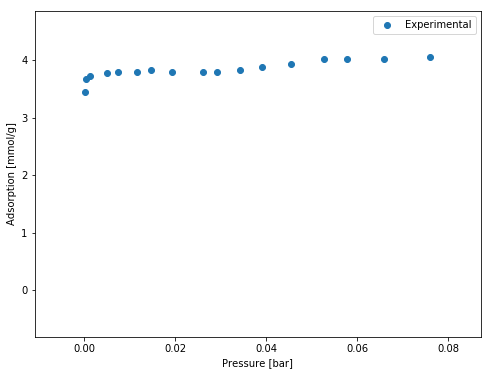

Calculated K = 82.04675245437986
Starting points: 18
Selected points: 18
Final adjusted root mean square difference: 0.5625974016720866


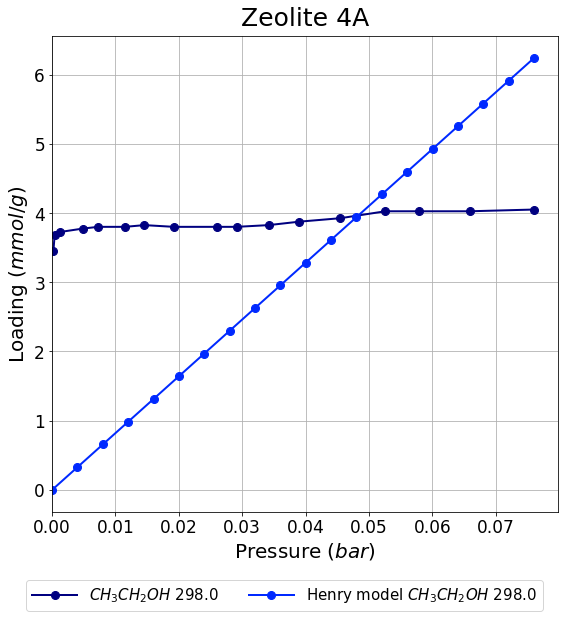

array([0.00020222, 0.00040444, 0.00121332, 0.00485327, 0.00727991,
       0.0115265 , 0.0145598 , 0.0192109 , 0.0260864 , 0.0291196 ,
       0.0341751 , 0.0390284 , 0.0454995 , 0.0525771 , 0.0578349 ,
       0.0659237 , 0.0760346 ])

In [64]:
bad_iso2 = Isotherm('10.1021Jp805923k.Isotherm3-1')
bad_iso2.convert_units()
bad_iso2.plot_isotherm()
bad_iso2.pressure = bad_iso2.pressure #* 1e10
bad_iso2.fit_henry_constant(1e100, True)
bad_iso2.add_comment('ethanol adsorption, low pressures, extremely high initial slope', henry_df)
bad_iso2.pressure

In [65]:
bad_iso2.adsorption

array([3.45 , 3.675, 3.725, 3.775, 3.8  , 3.8  , 3.825, 3.8  , 3.8  ,
       3.8  , 3.825, 3.875, 3.925, 4.025, 4.025, 4.025, 4.05 ])

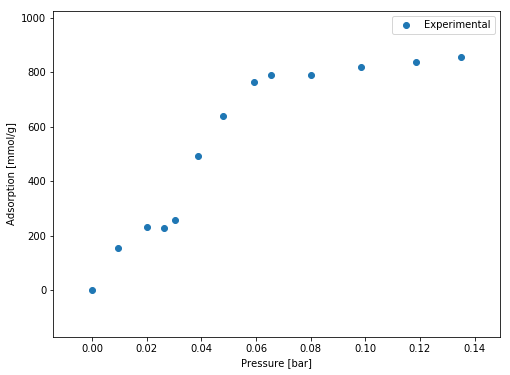

Calculated K = 8457.156781517959
Starting points: 13
Selected points: 13
Final adjusted root mean square difference: 0.18904669947254513


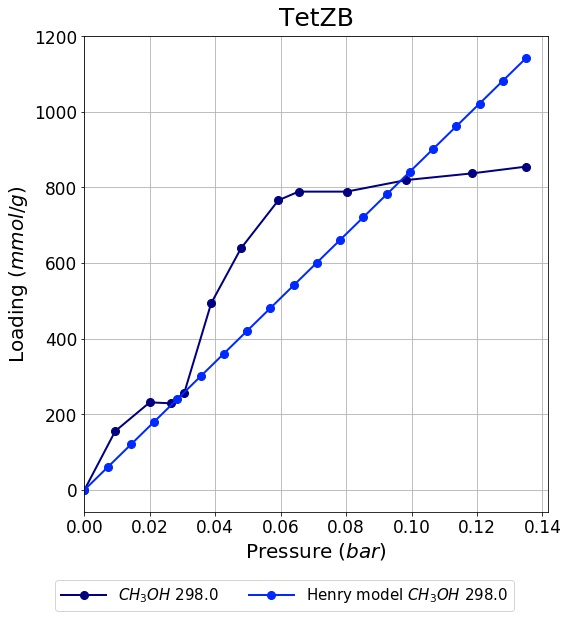

array([0.      , 0.009393, 0.019961, 0.026418, 0.030528, 0.038747,
       0.047846, 0.059294, 0.065459, 0.080136, 0.098335, 0.118589,
       0.135027])

In [66]:
bad_iso2 = Isotherm('10.1039c5cc00113g.Isotherm2')
bad_iso2.convert_units()
bad_iso2.plot_isotherm()
bad_iso2.pressure = bad_iso2.pressure #* 1e10
bad_iso2.fit_henry_constant(1e100, True)
bad_iso2.add_comment('methanol adsorption, low pressures', henry_df)
bad_iso2.pressure

In [67]:
bad_iso2.adsorption

array([  0.        , 155.19791922, 231.52463683, 228.98046493,
       256.96698007, 493.57933653, 638.60212859, 765.81072385,
       788.70889518, 788.70889518, 819.24083059, 837.05190647,
       854.85986144])

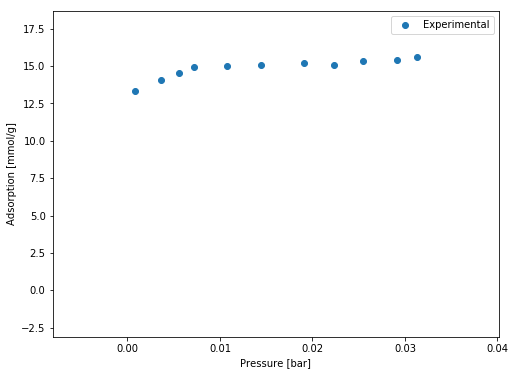

Calculated K = 687.9188312080282
Starting points: 12
Selected points: 12
Final adjusted root mean square difference: 0.4763029972004351


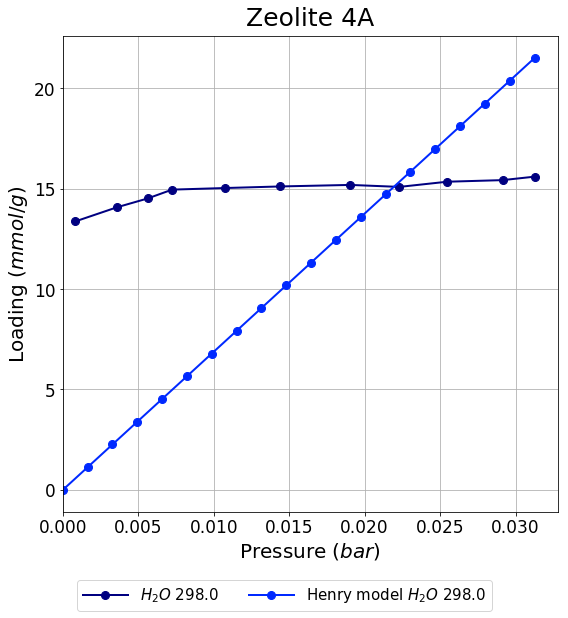

array([0.00081391, 0.00358121, 0.00561599, 0.00724382, 0.0107436 ,
       0.0144062 , 0.0190455 , 0.0223012 , 0.0254754 , 0.029138  ,
       0.0312542 ])

In [68]:
bad_iso2 = Isotherm('10.1021Jp805923k.Isotherm2-2')
bad_iso2.convert_units()
bad_iso2.plot_isotherm()
bad_iso2.pressure = bad_iso2.pressure #* 1e10
bad_iso2.fit_henry_constant(1e100, True)
bad_iso2.add_comment('water adsorption, low pressures, high intial slope', henry_df)
bad_iso2.pressure

In [69]:
bad_iso2.adsorption

array([13.364 , 14.0691, 14.5088, 14.9498, 15.0289, 15.1077, 15.1836,
       15.0853, 15.3436, 15.4223, 15.5945])

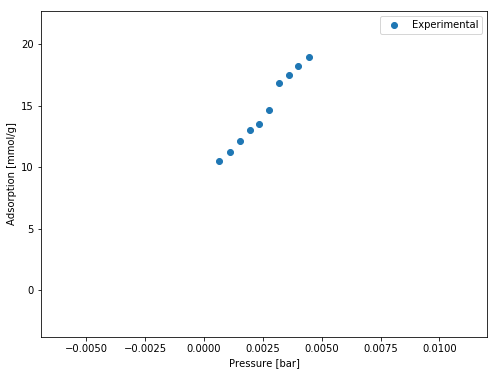

Calculated K = 5132.220511375368
Starting points: 11
Selected points: 11
Final adjusted root mean square difference: 0.18569705238256562


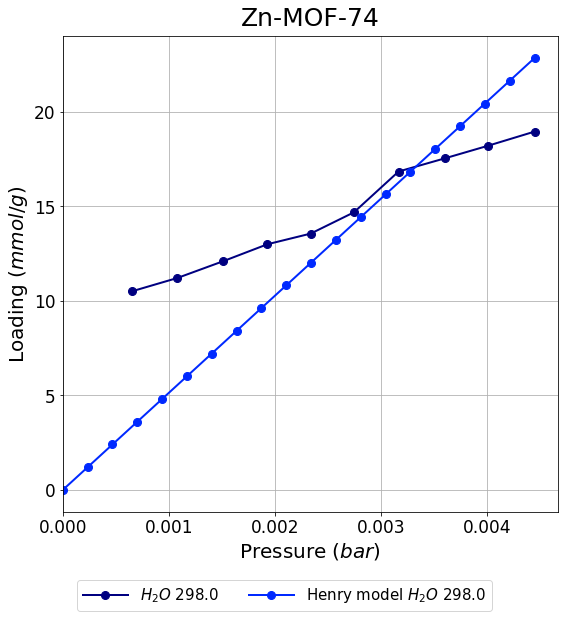

array([0.000654  , 0.0010819 , 0.00151599, 0.00193063, 0.0023388 ,
       0.00274697, 0.0031681 , 0.00360866, 0.00401035, 0.00445092])

In [70]:
bad_iso2 = Isotherm('10.1016j.ces.2010.10.002.isotherm7')
bad_iso2.convert_units()
bad_iso2.plot_isotherm()
bad_iso2.pressure = bad_iso2.pressure #* 1e10
bad_iso2.fit_henry_constant(1e100, True)
bad_iso2.add_comment('water adsorption', henry_df)
bad_iso2.pressure

In [71]:
bad_iso2.adsorption

array([10.5080243 , 11.21164922, 12.10289266, 12.9941916 , 13.55710264,
       14.68286921, 16.8406486 , 17.54427353, 18.20099382, 18.95157888])

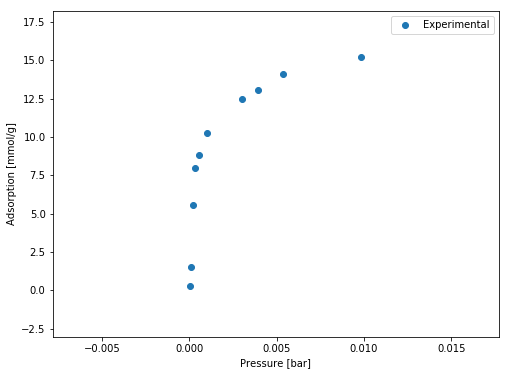

Calculated K = 2196.2923121383196
Starting points: 11
Selected points: 11
Final adjusted root mean square difference: 0.34599176202170046


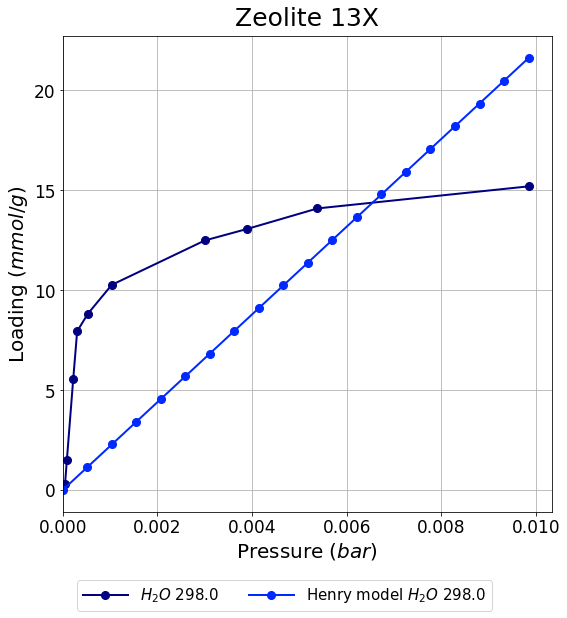

array([4.66000e-05, 8.52000e-05, 2.19000e-04, 3.03000e-04, 5.32000e-04,
       1.03362e-03, 3.00300e-03, 3.90093e-03, 5.38270e-03, 9.84430e-03])

In [72]:
bad_iso2 = Isotherm('10.1016S0009-2509(00)00531-5.Isotherm8')
bad_iso2.convert_units()
bad_iso2.plot_isotherm()
bad_iso2.pressure = bad_iso2.pressure #* 1e10
bad_iso2.fit_henry_constant(1e100, True)
bad_iso2.add_comment('water adsorption', henry_df)
bad_iso2.pressure

In [73]:
bad_iso2.adsorption

array([ 0.291367,  1.4871  ,  5.5283  ,  7.94151 ,  8.82643 , 10.2643  ,
       12.4894  , 13.0679  , 14.0922  , 15.1968  ])

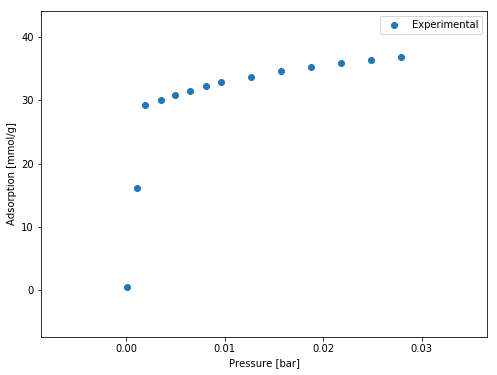

Calculated K = 1903.5001899668675
Starting points: 15
Selected points: 15
Final adjusted root mean square difference: 0.39964826987805374


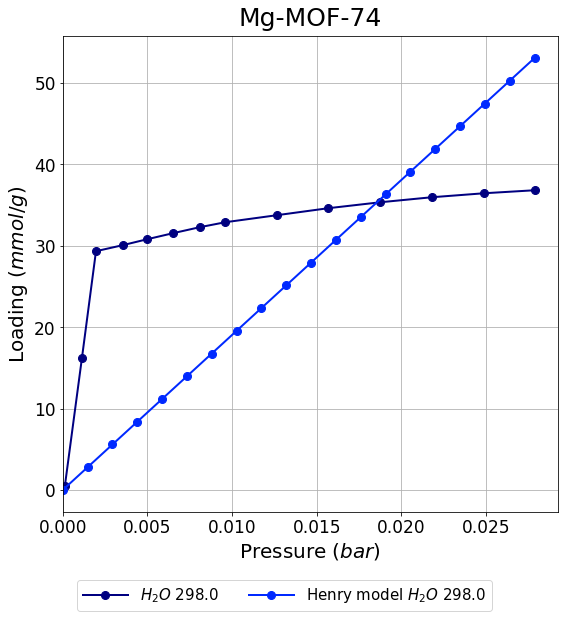

array([0.00012067, 0.00112889, 0.0019589 , 0.00353622, 0.00499212,
       0.00650873, 0.00808605, 0.00960285, 0.012637  , 0.0156712 ,
       0.0187662 , 0.0218007 , 0.0248962 , 0.0278704 ])

In [74]:
bad_iso2 = Isotherm('10.1021Ie202325p.Isotherm1')
bad_iso2.convert_units()
bad_iso2.plot_isotherm()
bad_iso2.pressure = bad_iso2.pressure #* 1e10
bad_iso2.fit_henry_constant(1e100, True)
bad_iso2.add_comment('water adsorption', henry_df)
bad_iso2.pressure

In [75]:
bad_iso2.adsorption

array([ 0.490798, 16.1963  , 29.3252  , 30.0613  , 30.7975  , 31.5337  ,
       32.2699  , 32.8834  , 33.7423  , 34.6012  , 35.3374  , 35.9509  ,
       36.4417  , 36.8098  ])

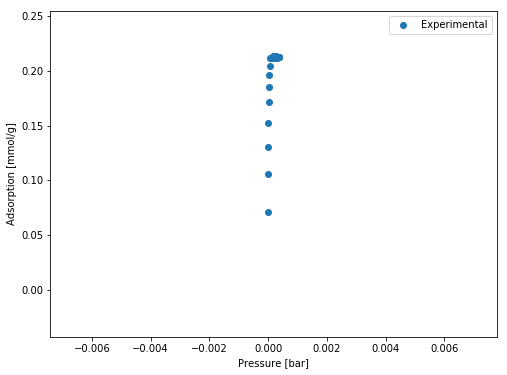

Calculated K = 823.7515943769796
Starting points: 45
Selected points: 45
Final adjusted root mean square difference: 0.4112684653475223


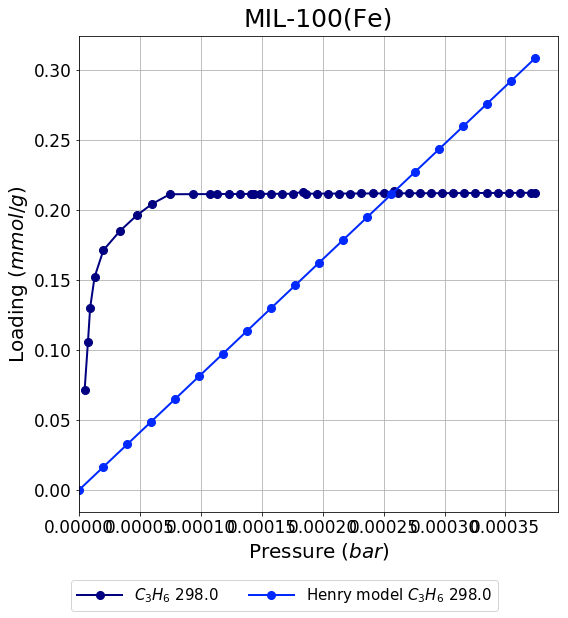

array([4.54508e-06, 7.27214e-06, 9.09016e-06, 1.27262e-05, 1.99984e-05,
       3.36336e-05, 4.72688e-05, 5.99951e-05, 7.45393e-05, 9.36287e-05,
       1.07264e-04, 1.13627e-04, 1.22717e-04, 1.31807e-04, 1.40898e-04,
       1.43624e-04, 1.48169e-04, 1.57260e-04, 1.66350e-04, 1.75440e-04,
       1.83621e-04, 1.86349e-04, 1.95439e-04, 2.04529e-04, 2.13618e-04,
       2.22708e-04, 2.31800e-04, 2.40890e-04, 2.49979e-04, 2.58160e-04,
       2.61797e-04, 2.70887e-04, 2.79977e-04, 2.89067e-04, 2.98157e-04,
       3.07248e-04, 3.16338e-04, 3.25428e-04, 3.34518e-04, 3.43608e-04,
       3.52698e-04, 3.61789e-04, 3.70879e-04, 3.74515e-04])

In [76]:
bad_iso2 = Isotherm('10.1039C1cp20502a.Isotherm7')
bad_iso2.convert_units()
bad_iso2.plot_isotherm()
bad_iso2.pressure = bad_iso2.pressure #* 1e10
bad_iso2.fit_henry_constant(1e100, True)
bad_iso2.add_comment('cyclopropane adsorption, incorrect pressure scale (c3h6 has vapor pressure of 5.41e03mmHg = ~7.2bar)', henry_df)
bad_iso2.pressure

In [77]:
bad_iso2.adsorption

array([0.0712484, 0.105504 , 0.130168 , 0.152098 , 0.171301 , 0.185047 ,
       0.196052 , 0.204315 , 0.211214 , 0.21128  , 0.211326 , 0.211348 ,
       0.211379 , 0.21141  , 0.211441 , 0.211451 , 0.211466 , 0.211498 ,
       0.211529 , 0.21156  , 0.212958 , 0.211597 , 0.211628 , 0.211659 ,
       0.211691 , 0.211722 , 0.211753 , 0.211784 , 0.211815 , 0.213213 ,
       0.211856 , 0.211887 , 0.211918 , 0.211949 , 0.21198  , 0.212011 ,
       0.212042 , 0.212073 , 0.212105 , 0.212136 , 0.212167 , 0.212198 ,
       0.212229 , 0.212242 ])

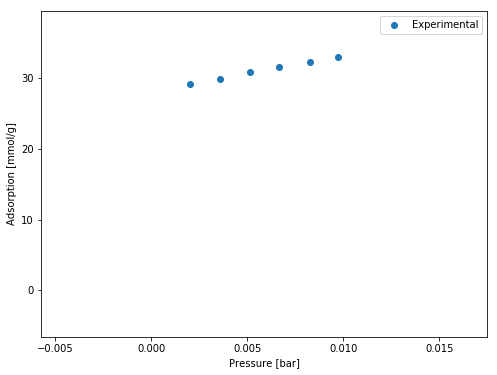

Calculated K = 4487.68680374342
Starting points: 7
Selected points: 7
Final adjusted root mean square difference: 0.32341834415433934


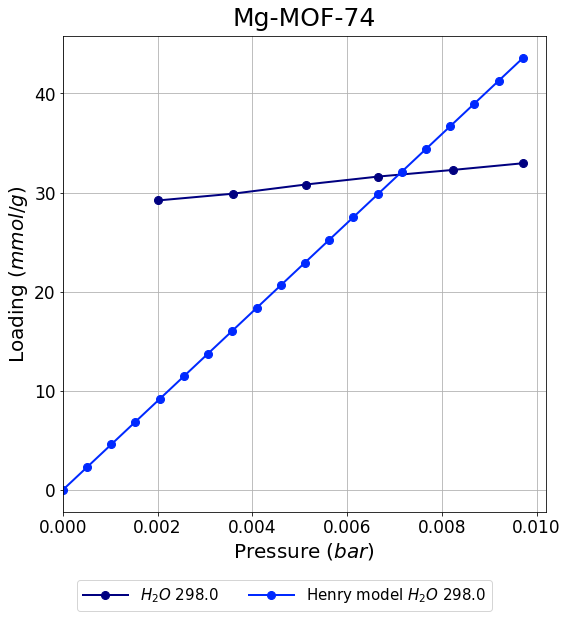

array([0.00201775, 0.00358296, 0.00512921, 0.00665631, 0.0082406 ,
       0.00971038])

In [78]:
bad_iso2 = Isotherm('10.1021Ct500094w.Isotherm6')
bad_iso2.convert_units()
bad_iso2.plot_isotherm()
bad_iso2.pressure = bad_iso2.pressure #* 1e10
bad_iso2.fit_henry_constant(1e100, True)
bad_iso2.add_comment('water adsorption', henry_df)
bad_iso2.pressure

In [79]:
henry_df.to_csv('henry_df_mel.csv')